In [1]:
from collections import Counter, defaultdict
import datetime
import geopandas as gpd
import json
import numpy as np
from math import radians
import matplotlib.pyplot as plt
import pandas as pd
import pgeocode
from shapely.geometry import Point
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import haversine_distances
from uszipcode import SearchEngine

In [2]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.rcParams.update({'font.size': 22})

In [4]:
market_area = 'boston'
state = 'MA'

In [5]:
data_dir = 'index-team-data'
neighborhood_scout_dir = 'neighborhood_scout_data'
data_path = f'../{data_dir}/{market_area}'
ct_data_path = f'{data_path}/census_tract_datasets'
neighborhood_scout_path = f'../{data_dir}/{neighborhood_scout_dir}'

In [8]:
with open(f'{data_path}/zipcodes.txt', 'r') as f:
    market_area_zipcodes = sorted(json.loads(f.read()))

### Process Neighborhood Scout data

In [9]:
# dataframe mapping ZIP code to census tract (note: a census tract can be in multiple ZIP codes)
zipcode_mapping_df = pd.read_csv(f'{neighborhood_scout_path}/zip_tract_crosswalk_2020.csv')
zipcode_mapping_df = zipcode_mapping_df[zipcode_mapping_df['ZIP'].isin(market_area_zipcodes)]

In [10]:
zipcode_mapping_df.head()

,ZIP,TRACT,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
1516,1005,25027722100,0.992387,1.0,0.985401,0.992145
1517,1005,25027721101,0.000000,0.0,0.014599,0.000982
1518,1005,25027704200,0.007613,0.0,0.000000,0.006873
1578,1031,25027723100,1.000000,1.0,1.000000,1.000000
1587,1037,25027723100,0.000000,1.0,1.000000,1.000000


In [11]:
# census tracts in market area
market_area_census_tracts = set(zipcode_mapping_df['TRACT'])

In [12]:
len(market_area_census_tracts)

1109

In [13]:
# dataframe reporting census tract-level statistics
all_ct_stats_df = pd.read_csv(f'{neighborhood_scout_path}/census_tract_2020_q3.csv')

In [14]:
# census tracts in entire state of interest
statewide_census_tracts = set(all_ct_stats_df[all_ct_stats_df['state'] == state]['ct_key'])

In [15]:
# limit analysis to census tracts in market area
ct_stats_df = all_ct_stats_df[all_ct_stats_df['ct_key'].isin(market_area_census_tracts)]
ct_stats_df.drop(columns=['state'], inplace=True)

In [16]:
ct_stats_df.shape

(1109, 61)

In [17]:
ct_stats_df.isna().sum()

ct_key                 0
rent.ct                0
grrent_yield.ct        0
rent_br3.ct            0
rent_br2.ct            0
rent_br1.ct            0
rent_br0.ct            0
cos.ct                 0
lake.ct                0
frm.ct                 0
pop_density.ct         0
den.ct                 0
urb.ct                 0
sub.ct                 0
rur.ct                 0
rmt.ct                 0
new_pct.ct             0
est_pct.ct             0
old_pct.ct             0
his_pct.ct             0
det_pct.ct             0
att_pct.ct             0
sap_pct.ct             0
lap_pct.ct             0
mob_pct.ct             0
oth_pct.ct             0
bed0_pct.ct            0
bed1_pct.ct            0
bed2_pct.ct            0
bed3_pct.ct            0
bed4_pct.ct            0
bed5_pct.ct            0
base_pct.ct            0
dorms_pct.ct           0
incarc_pct.ct          0
publichou_pct.ct       0
own_pct.ct             0
rnt_pct.ct             0
seasonal_pct.ct        0
vacant_pct.ct          0


### School district data

In [18]:
# dataframe mapping school district to census tract
school_mapping_df = pd.read_csv(f'{neighborhood_scout_path}/ct_schooldist_crosswalk_2020.csv')
school_mapping_df = school_mapping_df[['ct_key', 'leaid']]
ct_stats_df = ct_stats_df.merge(school_mapping_df, how='inner', on='ct_key')

In [19]:
ct_stats_df.shape

(1160, 62)

In [21]:
# dataframe reporting statistics for each school district
school_district_df = pd.read_csv(f'{neighborhood_scout_path}/school_district_2020.csv')
school_district_df.head()

,state,leaid,district_name.sd,member.sd,sch.sd,puptch.sd,stcls_total.sd,uscls_total.sd,usrpct_total.sd,strpct_total.sd
0,AZ,400001,CAVE CREEK UNIFIED DISTRICT (4244),5406,8,23.102564,8,9,81.810155,77.117117
1,AZ,400003,CHINO VALLEY UNIFIED DISTRICT (4474),2348,4,20.271087,6,5,43.544623,50.630631
2,AZ,400004,CLARKDALE-JEROME ELEMENTARY DISTRICT (4486),472,1,20.521739,7,7,65.234942,66.306306
3,AZ,400005,SALOME CONSOLIDATED ELEMENTARY DISTRICT (4514),113,1,14.125,2,1,5.994954,13.603604
4,AZ,400021,COLORADO CITY UNIFIED DISTRICT (4370),673,2,23.614035,7,7,65.689057,66.846847


In [22]:
school_district_df['avg_member.sd'] = school_district_df['member.sd'] / school_district_df['sch.sd']

In [23]:
school_district_df.drop(columns=['state', 'district_name.sd', 'member.sd', 'sch.sd'], 
                        inplace=True, errors='ignore')

In [24]:
ct_stats_df = ct_stats_df.merge(school_district_df, how='inner', on='leaid')

In [25]:
ct_stats_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [26]:
# convert string columns to float
for column in ct_stats_df.columns:
    if ct_stats_df[column].dtype == 'object':
        ct_stats_df[column] = ct_stats_df[column].astype('float64')

In [27]:
ct_stats_df.shape

(1160, 68)

In [28]:
# average statistics for census tracts that encompass multiple school districts
ct_stats_df = ct_stats_df.groupby('ct_key').mean().reset_index()
ct_stats_df.shape

(1109, 68)

### Individual school data

In [29]:
# dataframe reporting statistics for each school 
school_building_df = pd.read_csv(f'{neighborhood_scout_path}/school_building_2020.csv')
school_building_df = school_building_df[school_building_df['ct_key'].isin(market_area_census_tracts)]
school_building_df.drop(columns=['state', 'ncessch', 'name.sc', 'street.sc', 'city.sc'],
                        inplace=True)

In [30]:
school_building_df.head(5)

,state.sc,zip.sc,ct_key,member.sc,puptch.sc,stcls_total.sc,uscls_total.sc,usrpct_total.sc,strpct_total.sc
27290,MA,2657,25001010100,125,6.793478,3,5,49.556374,21.031456
27291,MA,2667,25001010206,105,8.076923,8,10,92.521154,73.994148
27292,MA,2666,25001010208,106,6.625,4,7,68.356473,37.271397
27293,MA,2642,25001010306,171,8.248915,8,10,91.251306,71.50695
27294,MA,2651,25001010306,937,11.54083,8,10,94.462896,75.954198


In [31]:
print('fraction of census tracts with data on schools:', (len(school_building_df['ct_key'].unique()) / 
                                                          len(market_area_census_tracts)))

fraction of census tracts with data on schools: 0.6780883678990082


In [32]:
# the fact that the set is empty confirms that each census tract is served by at least one school that
# we have data on
school_building_df_no_missing_vals = school_building_df[school_building_df['stcls_total.sc'] != ' ']
set(school_building_df_no_missing_vals['ct_key']) - set(school_building_df['ct_key'])

set()

In [33]:
school_building_df = school_building_df_no_missing_vals

In [34]:
print(school_building_df.shape)
school_building_df = school_building_df[school_building_df['ct_key'].notna()]
print(school_building_df.shape)

(1167, 9)
(1167, 9)


In [35]:
missing_poptch_indices = list(school_building_df[school_building_df['puptch.sc'] == ' '].index)

In [36]:
mean_inputation = np.mean([float(x) for x in school_building_df['puptch.sc'] if x != ' '])
for idx in missing_poptch_indices:
    school_building_df.at[idx, 'puptch.sc'] = mean_inputation

In [37]:
for column in ['stcls_total.sc', 'uscls_total.sc', 'member.sc', 'zip.sc']:
    school_building_df[column] = school_building_df[column].astype(int)
for column in ['puptch.sc', 'usrpct_total.sc', 'strpct_total.sc']:
    school_building_df[column] = school_building_df[column].astype(float)

In [38]:
school_building_df_zipcode = school_building_df.groupby('zip.sc').mean().reset_index().drop(columns=['ct_key'])

In [39]:
school_building_df_zipcode.head()

,zip.sc,member.sc,puptch.sc,stcls_total.sc,uscls_total.sc,usrpct_total.sc,strpct_total.sc
0,1005,482.333333,14.793838,4.666667,7.666667,69.690284,39.690236
1,1031,174.000000,14.032258,6.000000,9.000000,82.128816,55.998537
2,1068,127.000000,18.273381,5.000000,8.000000,77.939019,49.341624
3,1083,286.000000,12.341866,4.500000,7.500000,70.802281,40.606973
4,1092,435.000000,12.343927,5.000000,8.000000,70.964240,40.343819


In [40]:
# calculate average school statistics for census tracts that encompass multiple schools
school_building_df_ct = school_building_df.groupby('ct_key').mean().reset_index()
school_building_df_ct.drop(columns=['zip.sc'], inplace=True)

In [41]:
census_tracts_with_school = set(school_building_df_ct['ct_key'])
has_school_df = pd.DataFrame([(ct, int(ct in census_tracts_with_school)) for ct in market_area_census_tracts],
                             columns=['ct_key', 'has_school'])

In [42]:
census_tracts_no_school = set(has_school_df[has_school_df['has_school'] == 0]['ct_key'])

In [43]:
ct_no_school_zipcode_df = (zipcode_mapping_df[zipcode_mapping_df['TRACT'].isin(census_tracts_no_school)]
                           [['ZIP', 'TRACT']])

In [44]:
ct_no_school_zipcode_school_df = ct_no_school_zipcode_df.merge(school_building_df_zipcode,
                                                               left_on='ZIP',
                                                               right_on='zip.sc',
                                                               how='left')
ct_no_school_zipcode_school_df.drop(['ZIP', 'zip.sc'], axis=1, inplace=True)

In [45]:
ct_no_school_zipcode_school_df.head()

,TRACT,member.sc,puptch.sc,stcls_total.sc,uscls_total.sc,usrpct_total.sc,strpct_total.sc
0,25027703200,369.250000,14.205295,2.750000,5.500000,46.803226,21.222470
1,25011040502,369.250000,14.205295,2.750000,5.500000,46.803226,21.222470
2,25027703100,369.250000,14.205295,2.750000,5.500000,46.803226,21.222470
3,25027703200,138.000000,13.596059,7.000000,9.000000,89.252057,67.666423
4,25027710200,771.777778,13.597666,3.222222,5.777778,51.986144,26.350273


In [46]:
ct_no_school_zipcode_school_df = ct_no_school_zipcode_school_df.groupby('TRACT').mean().reset_index()

In [47]:
missing_tracts = ct_no_school_zipcode_school_df[ct_no_school_zipcode_school_df['member.sc'].isna()]['TRACT']
missing_school_indices = list(ct_no_school_zipcode_school_df[ct_no_school_zipcode_school_df['TRACT'].
                                                             isin(missing_tracts)].index)

In [48]:
ct_no_school_zipcode_school_df.columns

Index(['TRACT', 'member.sc', 'puptch.sc', 'stcls_total.sc', 'uscls_total.sc',
       'usrpct_total.sc', 'strpct_total.sc'],
      dtype='object')

In [49]:
for idx in missing_school_indices:
    for col in ct_no_school_zipcode_school_df.columns:
        if col not in {'TRACT', 'ncessch'}:
            if col == 'member.sc':
                ct_no_school_zipcode_school_df.at[idx, col] = np.mean(ct_no_school_zipcode_school_df['member.sc'])
            else:
                statistic = col.split('.')[0]
                ct_no_school_zipcode_school_df.at[idx, col] = ct_stats_df[statistic + '.sd'][idx]

In [50]:
ct_no_school_zipcode_school_df.rename({'TRACT': 'ct_key'}, axis=1, inplace=True)

In [51]:
combined_school_building_df = pd.concat([school_building_df_ct, ct_no_school_zipcode_school_df])

In [52]:
combined_school_building_df.shape

(1109, 7)

In [53]:
ct_stats_df = ct_stats_df.merge(combined_school_building_df, on='ct_key', how='left')

### Population Estimates

In [55]:
def convert_to_ct_key(df, l=-11):
    df['id'] = [int(ct[l:]) for ct in df['id']]
    df.rename({'id': 'ct_key'}, inplace=True, axis=1)
    return df

In [56]:
def read_in_dataset(filename):
    df = pd.read_csv(f'{ct_data_path}/{filename}.csv', header=1)
    df = convert_to_ct_key(df)
    df = df[df['ct_key'].isin(ct_stats_df['ct_key'])]
    return df

In [57]:
# AGE AND SEX (2018: ACS 5-Year Estimates Subject Tables)
# https://data.census.gov/cedsci/table?t=Populations%20and%20People&g=0400000US08.140000&tid=ACSST5Y2018.S0101&hidePreview=false
age_demographics_df = read_in_dataset('age_demographics')
age_demographics_df.rename({'Estimate!!Total!!Total population': 'census_population'}, axis=1, inplace=True)
age_census_pop_df = age_demographics_df[['ct_key', 'census_population']]

In [58]:
age_census_pop_df.head()

,ct_key,census_population
0,25001010100,2960
1,25001010206,3481
2,25001010208,1254
3,25001010304,2431
4,25001010306,2462


In [59]:
population_threshold = 1000
census_tracts_low_pop_df = age_census_pop_df[
    (age_census_pop_df['census_population'].isna()) |
    (age_census_pop_df['census_population'] < population_threshold)]

In [60]:
census_tracts_low_pop_df

,ct_key,census_population
43,25001014100,909
1137,25025020302,980
1292,25025980101,405
1293,25025980300,380
1294,25025980700,0
1295,25025981000,0
1296,25025981100,470
1297,25025981201,0
1298,25025981202,215
1299,25025981300,400


In [61]:
census_tracts_low_pop = list(census_tracts_low_pop_df['ct_key'])

In [62]:
# HOUSEHOLDS AND FAMILIES
household_size_df = read_in_dataset('household_size')
column_to_new_column = {'Estimate!!Total!!HOUSEHOLDS!!Total households': 'total_households'}
household_size_df = household_size_df[['ct_key'] + list(column_to_new_column)]
household_size_df.rename(column_to_new_column, axis=1, inplace=True)

In [63]:
census_tracts_no_households_df = household_size_df[household_size_df['total_households'] == 0]

In [64]:
census_tracts_no_households_df

,ct_key,total_households
1292,25025980101,0
1293,25025980300,0
1294,25025980700,0
1295,25025981000,0
1297,25025981201,0
1298,25025981202,0
1300,25025981501,0
1301,25025981502,0
1302,25025981600,0
1303,25025981700,0


In [65]:
census_tracts_no_households = list(census_tracts_no_households_df['ct_key'])

In [66]:
census_tracts_to_ignore = census_tracts_low_pop + census_tracts_no_households

In [67]:
# ignore census tracts that have 0 population or 0 households according to the Census Bureau
print(len(ct_stats_df))
ct_stats_df = ct_stats_df[~ct_stats_df['ct_key'].isin(census_tracts_to_ignore)]
print(len(ct_stats_df))

1109
1093


In [68]:
# add population to the census tract level features
ct_stats_df = ct_stats_df.merge(age_census_pop_df, on='ct_key', how='left')
ct_stats_df['census_population'] = ct_stats_df['census_population'].astype(int)

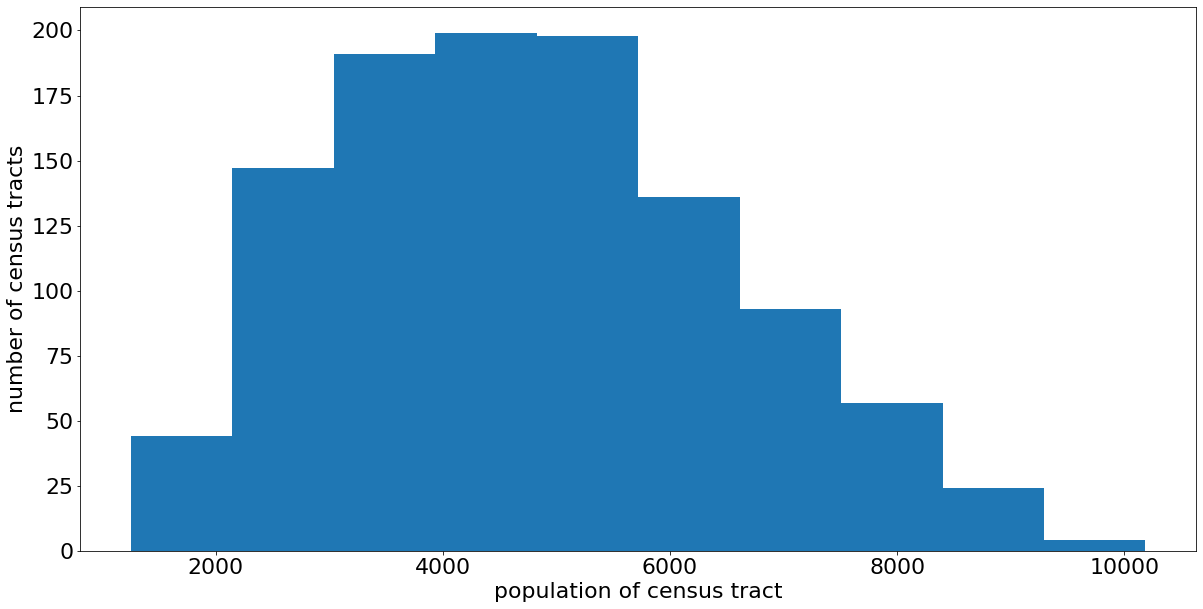

In [69]:
plt.figure(figsize=(20, 10))
plt.hist(ct_stats_df['census_population'])
plt.xlabel('population of census tract')
plt.ylabel('number of census tracts')
plt.show()

## Adding features from Census Bureau

### Age demographics

Age brackets:
1. < 18
2. 18-24
3. 25-34
4. 35-49
5. 50-59
6. 60-64
7. 65-74
8. 75+

In [70]:
age_demographics_df.head(2)

,ct_key,Geographic Area Name,census_population,Margin of Error!!Total MOE!!Total population,Estimate!!Percent!!Total population,Margin of Error!!Percent MOE!!Total population,Estimate!!Male!!Total population,Margin of Error!!Male MOE!!Total population,Estimate!!Percent Male!!Total population,Margin of Error!!Percent Male MOE!!Total population,Estimate!!Female!!Total population,Margin of Error!!Female MOE!!Total population,Estimate!!Percent Female!!Total population,Margin of Error!!Percent Female MOE!!Total population,Estimate!!Total!!Total population!!AGE!!Under 5 years,Margin of Error!!Total MOE!!Total population!!AGE!!Under 5 years,Estimate!!Percent!!Total population!!AGE!!Under 5 years,Margin of Error!!Percent MOE!!Total population!!AGE!!Under 5 years,Estimate!!Male!!Total population!!AGE!!Under 5 years,Margin of Error!!Male MOE!!Total population!!AGE!!Under 5 years,Estimate!!Percent Male!!Total population!!AGE!!Under 5 years,Margin of Error!!Percent Male MOE!!Total population!!AGE!!Under 5 years,Estimate!!Female!!Total population!!AGE!!Under 5 years,Margin of Error!!Female MOE!!Total population!!AGE!!Under 5 years,Estimate!!Percent Female!!Total population!!AGE!!Under 5 years,Margin of Error!!Percent Female MOE!!Total population!!AGE!!Under 5 years,Estimate!!Total!!Total population!!AGE!!5 to 9 years,Margin of Error!!Total MOE!!Total population!!AGE!!5 to 9 years,Estimate!!Percent!!Total population!!AGE!!5 to 9 years,Margin of Error!!Percent MOE!!Total population!!AGE!!5 to 9 years,Estimate!!Male!!Total population!!AGE!!5 to 9 years,Margin of Error!!Male MOE!!Total population!!AGE!!5 to 9 years,Estimate!!Percent Male!!Total population!!AGE!!5 to 9 years,Margin of Error!!Percent Male MOE!!Total population!!AGE!!5 to 9 years,Estimate!!Female!!Total population!!AGE!!5 to 9 years,Margin of Error!!Female MOE!!Total population!!AGE!!5 to 9 years,Estimate!!Percent Female!!Total population!!AGE!!5 to 9 years,Margin of Error!!Percent Female MOE!!Total population!!AGE!!5 to 9 years,Estimate!!Total!!Total population!!AGE!!10 to 14 years,Margin of Error!!Total MOE!!Total population!!AGE!!10 to 14 years,Estimate!!Percent!!Total population!!AGE!!10 to 14 years,Margin of Error!!Percent MOE!!Total population!!AGE!!10 to 14 years,Estimate!!Male!!Total population!!AGE!!10 to 14 years,Margin of Error!!Male MOE!!Total population!!AGE!!10 to 14 years,Estimate!!Percent Male!!Total population!!AGE!!10 to 14 years,Margin of Error!!Percent Male MOE!!Total population!!AGE!!10 to 14 years,Estimate!!Female!!Total population!!AGE!!10 to 14 years,Margin of Error!!Female MOE!!Total population!!AGE!!10 to 14 years,Estimate!!Percent Female!!Total population!!AGE!!10 to 14 years,Margin of Error!!Percent Female MOE!!Total population!!AGE!!10 to 14 years,Estimate!!Total!!Total population!!AGE!!15 to 19 years,Margin of Error!!Total MOE!!Total population!!AGE!!15 to 19 years,Estimate!!Percent!!Total population!!AGE!!15 to 19 years,Margin of Error!!Percent MOE!!Total population!!AGE!!15 to 19 years,Estimate!!Male!!Total population!!AGE!!15 to 19 years,Margin of Error!!Male MOE!!Total population!!AGE!!15 to 19 years,Estimate!!Percent Male!!Total population!!AGE!!15 to 19 years,Margin of Error!!Percent Male MOE!!Total population!!AGE!!15 to 19 years,Estimate!!Female!!Total population!!AGE!!15 to 19 years,Margin of Error!!Female MOE!!Total population!!AGE!!15 to 19 years,Estimate!!Percent Female!!Total population!!AGE!!15 to 19 years,Margin of Error!!Percent Female MOE!!Total population!!AGE!!15 to 19 years,Estimate!!Total!!Total population!!AGE!!20 to 24 years,Margin of Error!!Total MOE!!Total population!!AGE!!20 to 24 years,Estimate!!Percent!!Total population!!AGE!!20 to 24 years,Margin of Error!!Percent MOE!!Total population!!AGE!!20 to 24 years,Estimate!!Male!!Total population!!AGE!!20 to 24 years,Margin of Error!!Male MOE!!Total population!!AGE!!20 to 24 years,Estimate!!Percent Male!!Total population!!AGE!!20 to 24 years,Margin of Error!!Percent Male MOE!!Tot

In [71]:
age_group_to_column_endings = {'<18': ['Under 18 years'],
                               '18-24': ['18 to 24'],
                               '25-34': ['25 to 29', '30 to 34'],
                               '35-49': ['35 to 39', '40 to 44', '45 to 49'],
                               '50-59': ['50 to 54', '55 to 59'],
                               '60-64': ['60 to 64'],
                               '65-74': ['65 to 69', '70 to 74'],
                               '75+': ['75 to 79', '80 to 84', '85 years and over']}

In [72]:
age_breakdown_df = pd.DataFrame(age_demographics_df['ct_key'])

In [73]:
for age_group, column_endings in age_group_to_column_endings.items():
    cnt_array = np.zeros(len(age_demographics_df))
    for column_ending in column_endings:
        relevant_column = [column for column in age_demographics_df.columns
                           if (column.startswith('Estimate!!Total') 
                               and column.split('!!')[-1].startswith(column_ending))][0]
        cnt_array += age_demographics_df[relevant_column]
    age_breakdown_df[age_group] = cnt_array / age_demographics_df['census_population']

In [74]:
age_breakdown_df.head()

,ct_key,<18,18-24,25-34,35-49,50-59,60-64,65-74,75+
0,25001010100,0.048311,0.042568,0.045608,0.139189,0.284459,0.132770,0.184797,0.122297
1,25001010206,0.119793,0.105142,0.052858,0.084171,0.188164,0.107440,0.180695,0.161735
2,25001010208,0.105263,0.033493,0.010367,0.192982,0.093301,0.150718,0.317384,0.096491
3,25001010304,0.073221,0.104484,0.055533,0.115590,0.121349,0.110654,0.219663,0.199506
4,25001010306,0.130788,0.084078,0.050772,0.150690,0.142973,0.091389,0.188871,0.160439


In [75]:
ct_stats_df = ct_stats_df.merge(age_breakdown_df, on='ct_key', how='left')

### Racial demographics

In [76]:
# ACS demographic and housing estimates (2018: ACS 5-Year Estimates Data Profiles)
# (https://data.census.gov/cedsci/table?t=Housing&g=0400000US08.140000&tid=ACSDP5Y2010.DP05&hidePreview=false)
racial_demographics_df = read_in_dataset('racial_demographics')

In [77]:
race_to_column_ending = {'Hispanic': 'Hispanic or Latino (of any race)',
                         'White': 'White alone',
                         'Black': 'Black or African American alone',
                         'Asian': 'Asian alone'}

In [78]:
racial_breakdown_df = pd.DataFrame(racial_demographics_df['ct_key'])

In [79]:
for race, column_ending in race_to_column_ending.items():
    relevant_column = [column for column in racial_demographics_df.columns
                       if column.startswith('Estimate') and column.split('!!')[-1] == column_ending][0]
    racial_breakdown_df[race] = (racial_demographics_df[relevant_column] / 
                                 racial_demographics_df['Estimate!!RACE!!Total population'])

In [80]:
for race in race_to_column_ending:
    print(f'percentage of population in market area that is {race}:', 
          round(100 * np.mean(racial_breakdown_df[race]), 2))

percentage of population in market area that is Hispanic: 10.22
percentage of population in market area that is White: 71.12
percentage of population in market area that is Black: 7.86
percentage of population in market area that is Asian: 7.41


In [81]:
ct_stats_df = ct_stats_df.merge(racial_breakdown_df, on='ct_key', how='left')

### Population growth

In [82]:
sorted_filenames = ['ACSST5Y' + str(year) + '.S0101_data_with_overlays_2020-11-30T144409.csv'
                    for year in range(2010, 2019)]

ct_key_to_population_trend = defaultdict(list)

age_demographics_directory = f'{ct_data_path}/age_demographics_2010_2018'
for f in sorted_filenames:
    df = pd.read_csv(f'{age_demographics_directory}/{f}', header=1)
    df = convert_to_ct_key(df)
    try:
        population_column = 'Total!!Estimate!!Total population'
        df = df[['ct_key', population_column]]
    except KeyError:
        population_column = 'Estimate!!Total!!Total population'
        df = df[['ct_key', population_column]]
    
    for _, row in df.iterrows():
        ct_key_to_population_trend[row['ct_key']].append(row[population_column])

In [83]:
market_area_census_tracts = set(ct_stats_df['ct_key'])

In [84]:
lin_reg = LinearRegression()

# clip zipcodes that grow faster than an average of 10% per year
def calculate_growth_rate(population_trend, max_annual_growth=0.1):
    lin_reg.fit(np.arange(len(population_trend)).reshape(-1, 1), population_trend)
    slope = lin_reg.coef_[0] / population_trend[0]
    avg_yoy_change = np.mean([(population_trend[i + 1] - population_trend[i]) / population_trend[i] 
                               for i in range(len(population_trend) - 1)])
    
    return min(slope, max_annual_growth), min(avg_yoy_change, max_annual_growth)

In [85]:
population_growth_rate_lst = []
for ct_key, population_trend in ct_key_to_population_trend.items():
    if ct_key in market_area_census_tracts:
        population_trend_last_5_years = population_trend[-5:]
        slope_9_yr, avg_yoy_change_9_yr = calculate_growth_rate(population_trend)
        slope_5_yr, avg_yoy_change_5_yr = calculate_growth_rate(population_trend_last_5_years)
        population_growth_rate_lst.append((ct_key, slope_9_yr, avg_yoy_change_9_yr, 
                                           slope_5_yr, avg_yoy_change_5_yr))

In [86]:
columns = ['ct_key', 'linear_pop_trend_since_2010', 'avg_annual_pop_change_since_2010',
           'linear_pop_trend_since_2014', 'avg_annual_pop_change_since_2014']
ct_population_growth_df = pd.DataFrame(population_growth_rate_lst, columns=columns)

In [87]:
ct_population_growth_df.head()

,ct_key,linear_pop_trend_since_2010,avg_annual_pop_change_since_2010,linear_pop_trend_since_2014,avg_annual_pop_change_since_2014
0,25005600100,0.019353,0.014787,0.005860,0.006263
1,25005600202,0.017321,0.017905,0.024809,0.026793
2,25005600203,0.002479,0.003807,0.018011,0.018998
3,25005600204,0.011437,0.013819,0.001675,0.000456
4,25005610100,0.012029,0.013867,0.007396,0.007160


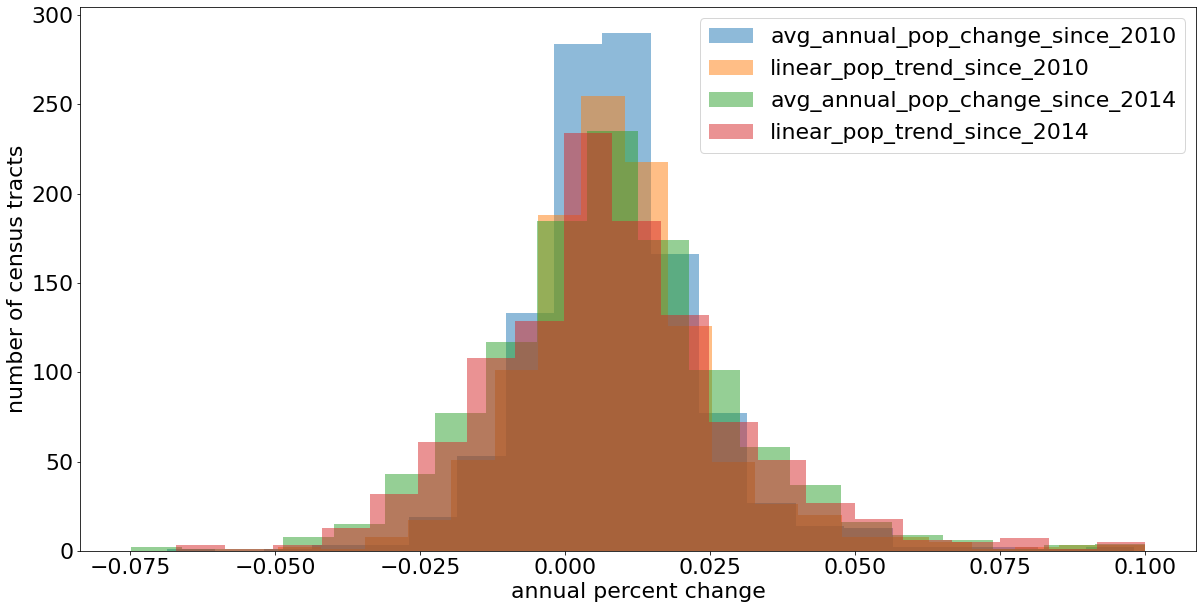

In [88]:
plt.figure(figsize=(20, 10))
plt.hist(ct_population_growth_df['avg_annual_pop_change_since_2010'], bins=20, alpha=0.5,
         label='avg_annual_pop_change_since_2010')
plt.hist(ct_population_growth_df['linear_pop_trend_since_2010'], bins=20, alpha=0.5,
         label='linear_pop_trend_since_2010')
plt.hist(ct_population_growth_df['avg_annual_pop_change_since_2014'], bins=20, alpha=0.5,
         label='avg_annual_pop_change_since_2014')
plt.hist(ct_population_growth_df['linear_pop_trend_since_2014'], bins=20, alpha=0.5,
         label='linear_pop_trend_since_2014')
plt.xlabel('annual percent change')
plt.ylabel('number of census tracts')
plt.legend()
plt.show()

In [89]:
ct_stats_df = ct_stats_df.merge(ct_population_growth_df, on='ct_key', how='left')

### Fertility

In [90]:
# Fertility 
# https://data.census.gov/cedsci/table?t=Fertility&g=0400000US08.140000&tid=ACSST5Y2018.S1301&hidePreview=false
fertility_df = read_in_dataset('fertility')
fertility_df.rename({'Estimate!!Women with births in the past 12 months!!Number!!Women 15 to 50 years': 
                     'number_of_births'}, axis=1, inplace=True)

In [91]:
fertility_df = fertility_df[['ct_key', 'number_of_births']]
fertility_df = fertility_df.merge(ct_stats_df[['ct_key', 'census_population']], on='ct_key', how='right')
fertility_df['annual_births_per_resident'] = fertility_df['number_of_births'] / fertility_df['census_population']

In [92]:
fertility_df.head()

,ct_key,number_of_births,census_population,annual_births_per_resident
0,25001010100,9,2960,0.003041
1,25001010206,0,3481,0.000000
2,25001010208,0,1254,0.000000
3,25001010304,0,2431,0.000000
4,25001010306,32,2462,0.012998


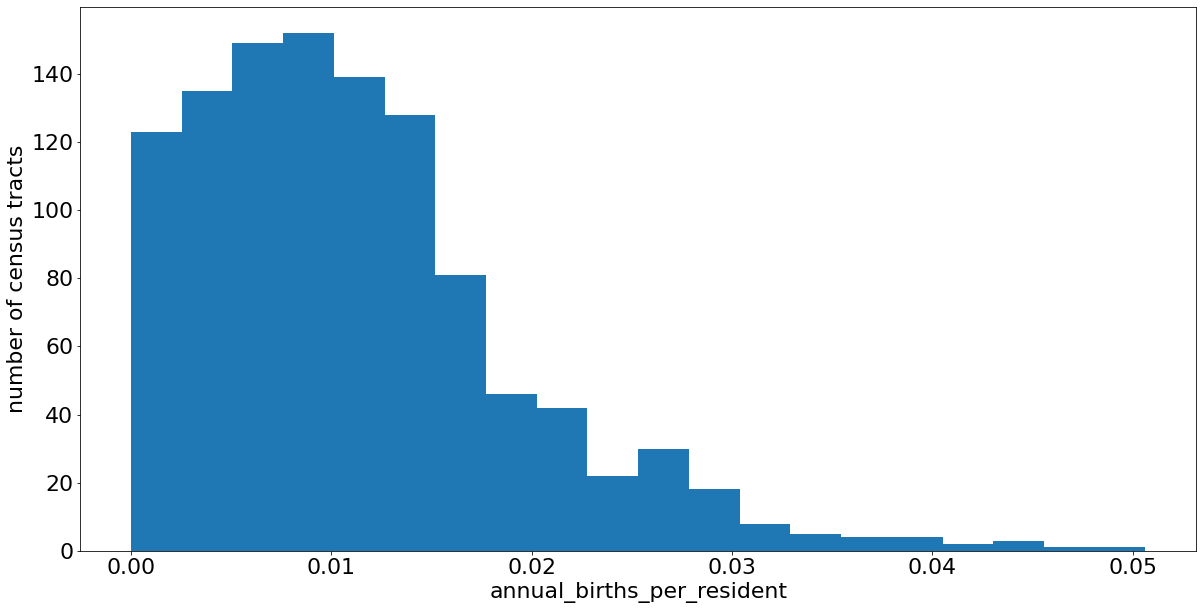

In [93]:
plt.figure(figsize=(20, 10))
plt.hist(fertility_df['annual_births_per_resident'], bins=20)
plt.xlabel('annual_births_per_resident')
plt.ylabel('number of census tracts')
plt.show()

In [94]:
ct_stats_df = ct_stats_df.merge(fertility_df[['ct_key', 'annual_births_per_resident']], on='ct_key', how='left')

### Commuting

In [95]:
# MEANS OF TRANSPORTATION TO WORK BY TENURE
# https://data.census.gov/cedsci/table?t=Housing&g=0400000US08.140000&tid=ACSDT5Y2018.B08137&hidePreview=false
commuting_df = read_in_dataset('commuting_mode')
commuting_df.rename({'Estimate!!Total': 'workforce_size'}, axis=1, inplace=True)

In [96]:
commuting_df = commuting_df.merge(ct_stats_df[['ct_key', 'census_population']], on='ct_key', how='right')
commuting_df['workforce_fraction'] = commuting_df['workforce_size'] / commuting_df['census_population']
transit_mode_df = commuting_df[['ct_key', 'workforce_fraction']]

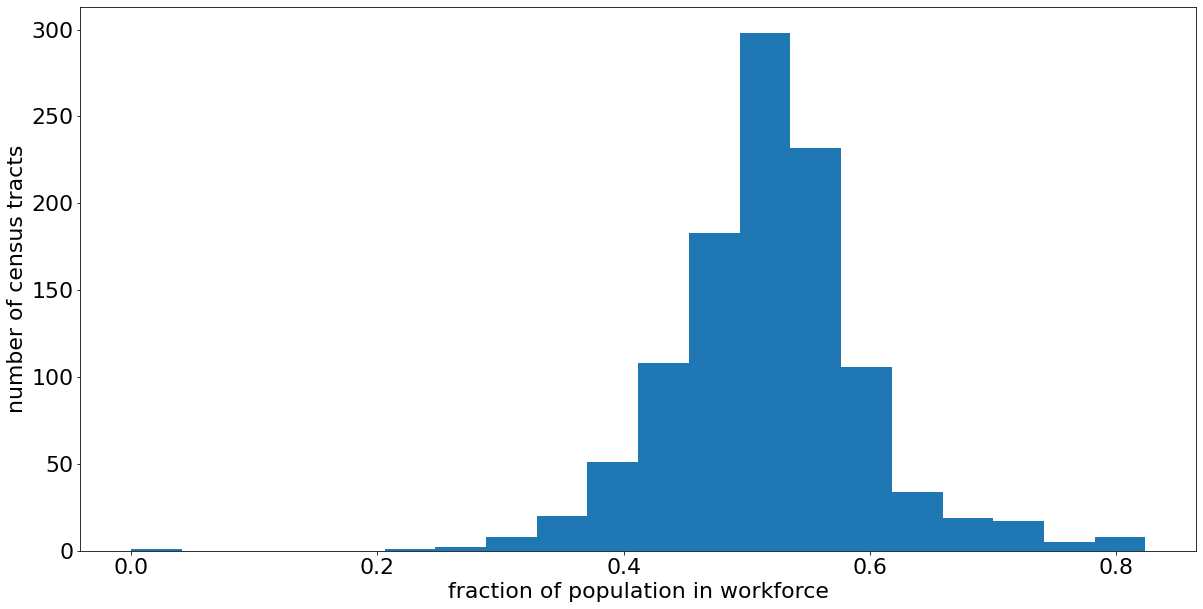

In [97]:
plt.figure(figsize=(20, 10))
plt.hist(transit_mode_df['workforce_fraction'], bins=20)
plt.xlabel('fraction of population in workforce')
plt.ylabel('number of census tracts')
plt.show()

In [98]:
transit_mode_to_column_ending = {'car': 'Car, truck, or van - drove alone', 
                                 'carpool': 'Car, truck, or van - carpooled',
                                 'public_transportation': 'Public transportation',
                                 'walk': 'Walked',
                                 'WFH': 'Worked at home',
                                 'other_mode_of_transit': 'Taxicab, motorcycle, bicycle'}

In [99]:
for transit_mode, column_ending in transit_mode_to_column_ending.items():
    relevant_column = [column for column in commuting_df.columns
                       if (column.startswith('Estimate!!Total') 
                           and column.split('!!')[-1].startswith(column_ending))][0]
    transit_mode_df[transit_mode] = commuting_df[relevant_column] / commuting_df['workforce_size']

In [100]:
transit_mode_df.head()

,ct_key,workforce_fraction,car,carpool,public_transportation,walk,WFH,other_mode_of_transit
0,25001010100,0.553716,0.368517,0.092739,0.020744,0.238560,0.152532,0.126907
1,25001010206,0.465384,0.674074,0.064198,0.016049,0.053086,0.157407,0.035185
2,25001010208,0.433014,0.558011,0.077348,0.000000,0.001842,0.348066,0.014733
3,25001010304,0.426162,0.775097,0.057915,0.017375,0.000000,0.138031,0.011583
4,25001010306,0.437449,0.781801,0.028784,0.000000,0.062210,0.089136,0.038069


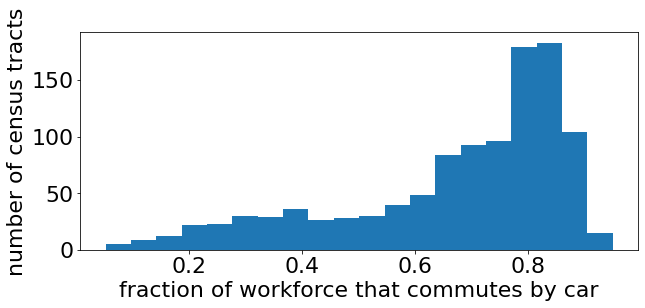

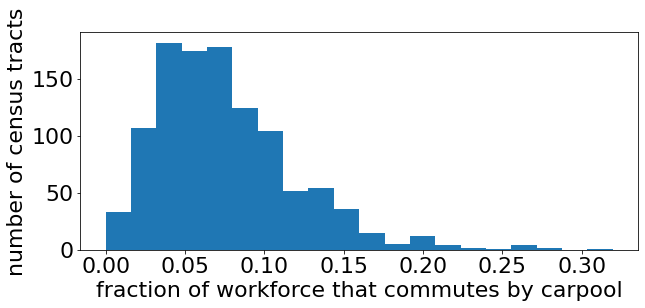

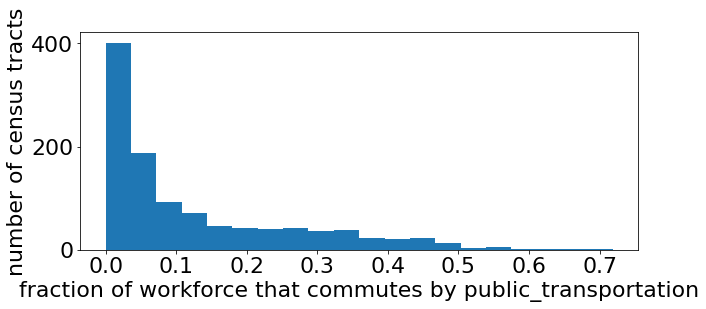

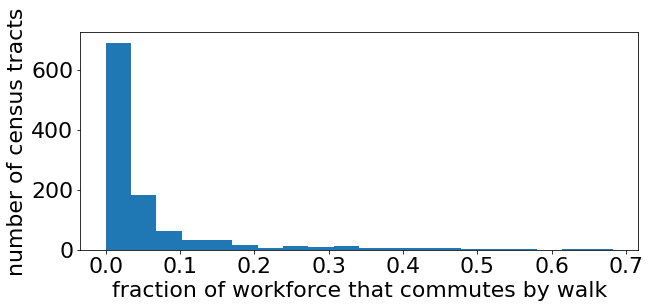

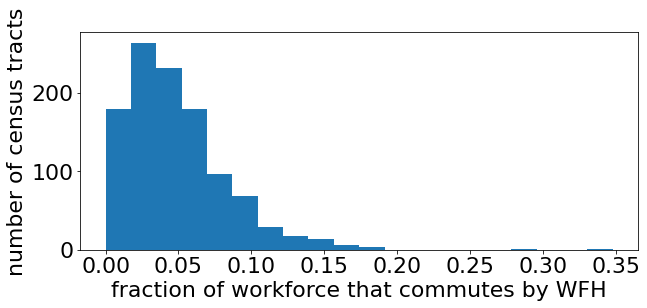

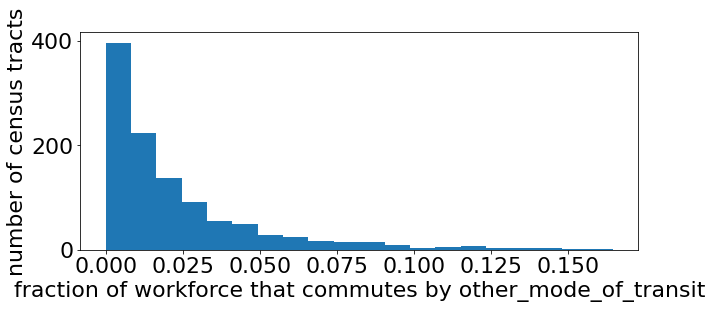

In [101]:
for transit_mode in transit_mode_to_column_ending:
    plt.figure(figsize=(10, 4))
    plt.hist(transit_mode_df[transit_mode], bins=20)
    plt.xlabel(f'fraction of workforce that commutes by {transit_mode}')
    plt.ylabel('number of census tracts')

In [102]:
ct_stats_df = ct_stats_df.merge(transit_mode_df, on='ct_key', how='left')

### Income

In [103]:
# INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)
# https://data.census.gov/cedsci/table?t=Income%20%28Households,%20Families,%20Individuals%29&g=0400000US08.140000&tid=ACSST5Y2018.S1901&hidePreview=false
income_df = read_in_dataset('income')
income_df = income_df[income_df['ct_key'].isin(market_area_census_tracts)]

According to https://www.census.gov/programs-surveys/cps/technical-documentation/subject-definitions.html

A household consists of all the people who occupy a housing unit. A house, an apartment or other group of rooms, or a single room, is regarded as a housing unit when it is occupied or intended for occupancy as separate living quarters; that is, when the occupants do not live with any other persons in the structure and there is direct access from the outside or through a common hall. 

A household includes the related family members and all the unrelated people, if any, such as lodgers, foster children, wards, or employees who share the housing unit. A person living alone in a housing unit, or a group of unrelated people sharing a housing unit such as partners or roomers, is also counted as a household. The count of households excludes group quarters. There are two major categories of households, "family" and "nonfamily". 

A family is a group of two people or more (one of whom is the householder) related by birth, marriage, or adoption and residing together; all such people (including related subfamily members) are considered as members of one family.

A nonfamily household consists of a householder living alone (a one-person household) or where the householder shares the home exclusively with people to whom he/she is not related.

In [104]:
column_to_new_column = {'Estimate!!Households!!Total': 'total_households',
                        'Estimate!!Families!!Total': 'total_families_households',
                        'Estimate!!Nonfamily households!!Total': 'total_nonfamily_households',
                        'Estimate!!Households!!Median income (dollars)': 'median_household_income',
                        'Estimate!!Families!!Median income (dollars)': 'median_family_income',
                        'Estimate!!Nonfamily households!!Median income (dollars)': 'median_nonfamily_income',
                        'Estimate!!Households!!Mean income (dollars)': 'mean_household_income',
                        'Estimate!!Families!!Mean income (dollars)': 'mean_family_income',
                        'Estimate!!Nonfamily households!!Mean income (dollars)': 'mean_nonfamily_income'}

In [105]:
income_df = income_df[['ct_key'] + list(column_to_new_column)]
income_df.rename(column_to_new_column, axis=1, inplace=True)

In [106]:
income_df['family_households_fraction'] = income_df['total_families_households'] / income_df['total_households']
income_df['nonfamily_households_fraction'] = (income_df['total_nonfamily_households'] / 
                                              income_df['total_households'])

income_df.drop(['total_households', 'total_families_households', 'total_nonfamily_households'], axis=1,
               inplace=True)

In [107]:
income_df[(income_df['median_family_income'] == '-') |
          (income_df['median_nonfamily_income'] == '-') |
          (income_df['mean_nonfamily_income'] == 'N')]

,ct_key,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,family_households_fraction,nonfamily_households_fraction
108,25005612100,100060,112237,-,112712,130273,52150,0.762670,0.237330
131,25005631200,94600,106714,-,107824,131006,47190,0.719188,0.280812
183,25005650600,36616,38547,-,42038,47576,34042,0.532198,0.467802
585,25017315403,113636,125096,-,116991,130635,61196,0.803509,0.196491
608,25017320104,162610,195354,-,183970,206541,71697,0.832611,0.167389
702,25017350104,58298,58404,-,72299,74936,62642,0.633434,0.366566
763,25017357500,110500,143646,-,135901,159184,90638,0.647674,0.352326
788,25017365100,183988,187466,-,226780,238919,112926,0.894934,0.105066
823,25017373900,159525,237984,-,254203,299900,106078,0.734645,0.265355
833,25017382100,121591,139773,-,137045,154989,66102,0.789760,0.210240


In [108]:
income_df.replace(to_replace='250,000+', value='250000', inplace=True)

In [109]:
for summary_stat in ['median', 'mean']:
    col_name = f'{summary_stat}_household_income'
    mean_val = int(np.mean([int(x) for x in income_df[col_name] if x not in {'-', 'N'}]))
    income_df[col_name] = [mean_val if x in {'-', 'N'} else int(x) for x in income_df[col_name]]

In [110]:
for summary_stat in ['median', 'mean']:
    for family_type in ['family', 'nonfamily']:
        income_df[f'{summary_stat}_{family_type}_income'] = (
            income_df.apply(lambda x: x[f'{summary_stat}_household_income']                         
            if x[f'{summary_stat}_{family_type}_income'] in {'-', 'N'} 
            else x[f'{summary_stat}_{family_type}_income'], axis=1))

In [111]:
for column in income_df.columns:
    if column.split('_')[0] in {'median', 'mean'}:
        income_df[column] = income_df[column].astype(float)

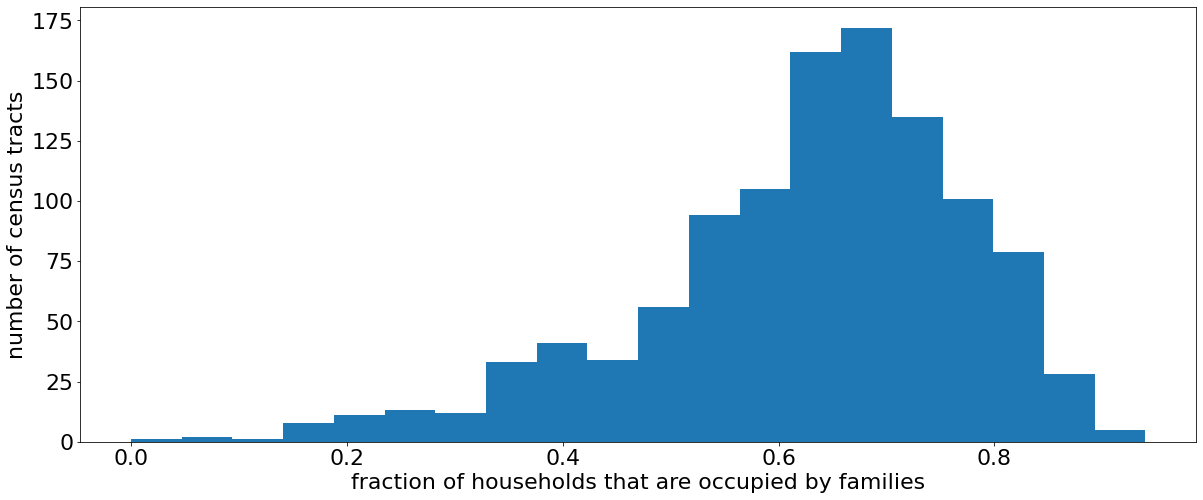

In [112]:
plt.figure(figsize=(20, 8))
plt.hist(income_df['family_households_fraction'], bins=20)
plt.xlabel('fraction of households that are occupied by families')
plt.ylabel('number of census tracts')
plt.show()

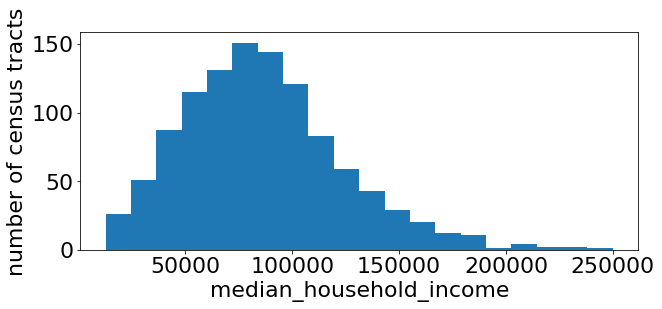

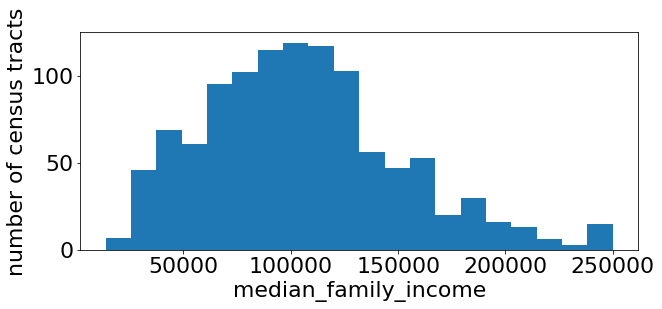

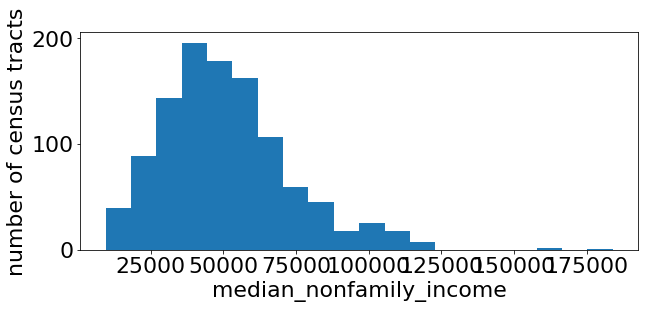

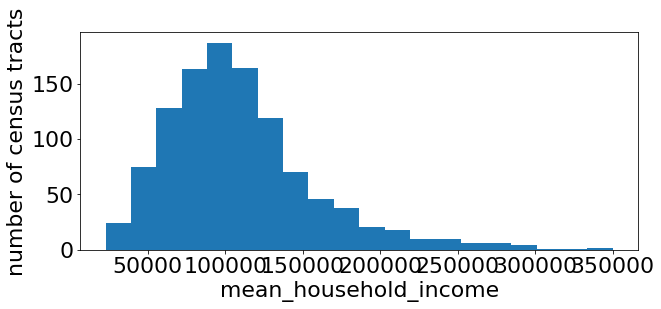

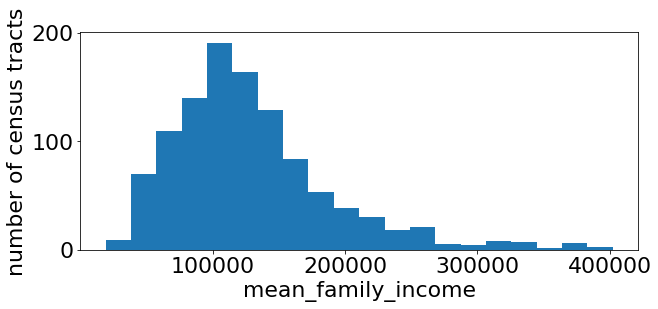

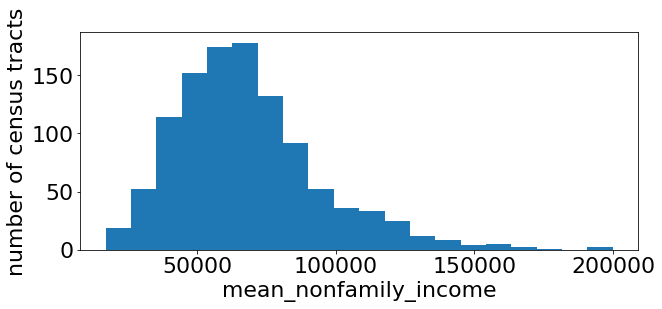

In [113]:
for column in income_df.columns:
    if column.split('_')[0] in {'median', 'mean'}:
        plt.figure(figsize=(10, 4))
        plt.hist(income_df[column], bins=20)
        plt.xlabel(column)
        plt.ylabel('number of census tracts')
        plt.show()

In [114]:
ct_stats_df = ct_stats_df.merge(income_df, on='ct_key', how='left')

### Poverty

In [115]:
# FOOD STAMPS/SUPPLEMENTAL NUTRITION ASSISTANCE PROGRAM (SNAP)
# https://data.census.gov/cedsci/table?t=SNAP%2FFood%20Stamps&g=0400000US08.140000&tid=ACSST5Y2018.S2201&hidePreview=false
food_stamps_df = read_in_dataset('food_stamps')

In [116]:
column_to_new_column = {
    'Estimate!!Percent!!Households!!POVERTY STATUS IN THE PAST 12 MONTHS!!At or above poverty level': 'above_poverty_line',
    'Estimate!!Percent households not receiving food stamps/SNAP!!Households!!POVERTY STATUS IN THE PAST 12 MONTHS!!Below poverty level': 'below_poverty_line'
}

In [117]:
poverty_df = food_stamps_df[['ct_key'] + list(column_to_new_column)]
poverty_df.rename(column_to_new_column, axis=1, inplace=True)

In [118]:
poverty_df.head()

,ct_key,above_poverty_line,below_poverty_line
0,25001010100,88,11
1,25001010206,92.9,5.6
2,25001010208,92.5,7.6
3,25001010304,94.5,4.9
4,25001010306,92.3,5.5


In [119]:
for column in ['above_poverty_line', 'below_poverty_line']:
    poverty_df[column] = [x if x != '-' else np.nan for x in poverty_df[column]]
    poverty_df[column] = poverty_df[column].astype(float)

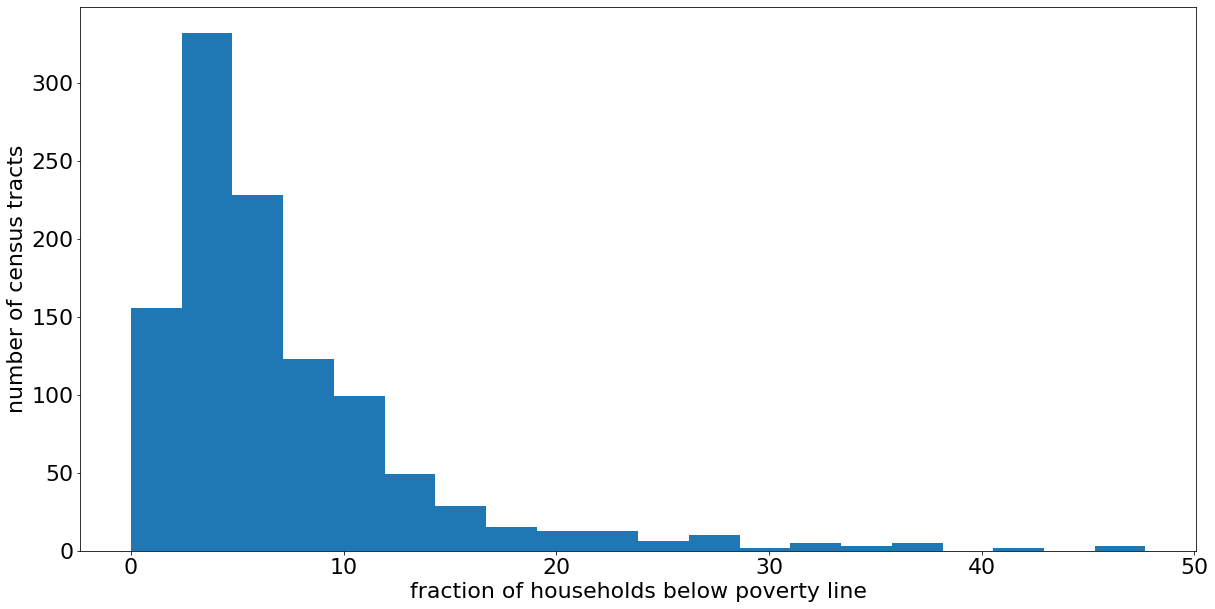

In [120]:
plt.figure(figsize=(20, 10))
plt.hist(poverty_df['below_poverty_line'], bins=20)
plt.xlabel('fraction of households below poverty line')
plt.ylabel('number of census tracts')
plt.show()

In [121]:
ct_stats_df = ct_stats_df.merge(poverty_df, on='ct_key', how='left')

### Occupation

In [122]:
# SELECTED ECONOMIC CHARACTERISTICS
# https://data.census.gov/cedsci/table?t=Income%20%28Households,%20Families,%20Individuals%29%3APoverty&g=0400000US08.140000&tid=ACSDP5Y2018.DP03&hidePreview=false
economic_df = read_in_dataset('economic_characteristics')

In [123]:
column_to_new_column = {
    'Percent Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Professional, scientific, and management, and administrative and waste management services': 'STEM_jobs',
    'Percent Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Educational services, and health care and social assistance': 'education&health_care'
}

In [124]:
occupation_df = economic_df[['ct_key'] + list(column_to_new_column)]
occupation_df.rename(column_to_new_column, axis=1, inplace=True)

In [125]:
occupation_df.head()

,ct_key,STEM_jobs,education&health_care
0,25001010100,8.9,21.8
1,25001010206,11.5,20.1
2,25001010208,14.1,22.8
3,25001010304,14.9,18.9
4,25001010306,12.1,16


In [126]:
for column in ['STEM_jobs', 'education&health_care']:
    occupation_df[column] = [x if x != '-' else np.nan for x in occupation_df[column]]
    occupation_df[column] = occupation_df[column].astype(float)

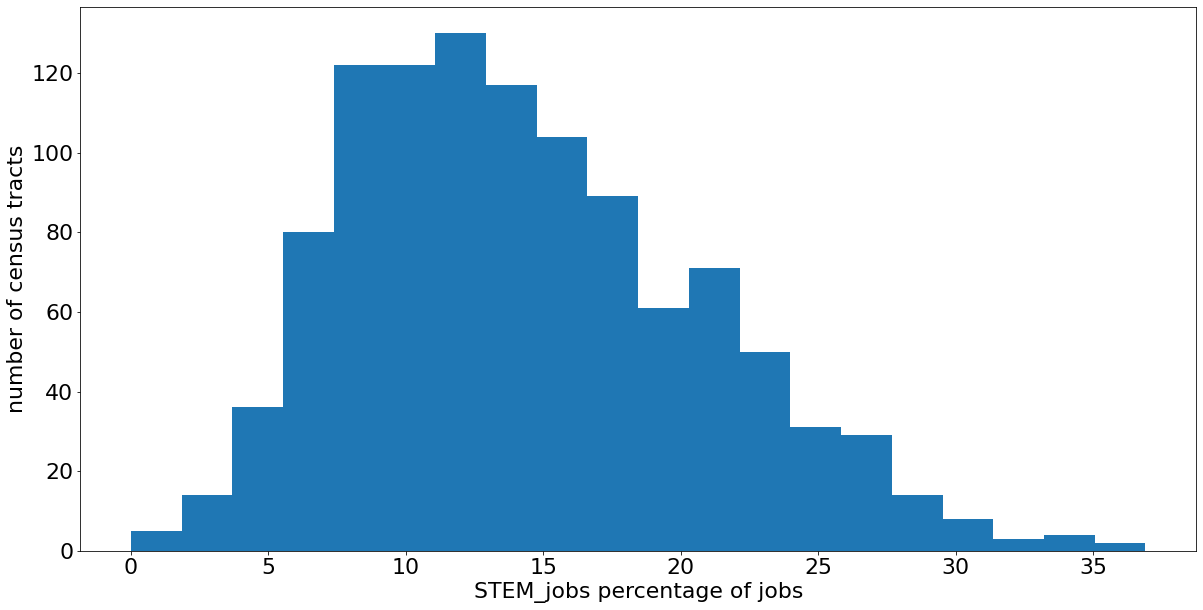

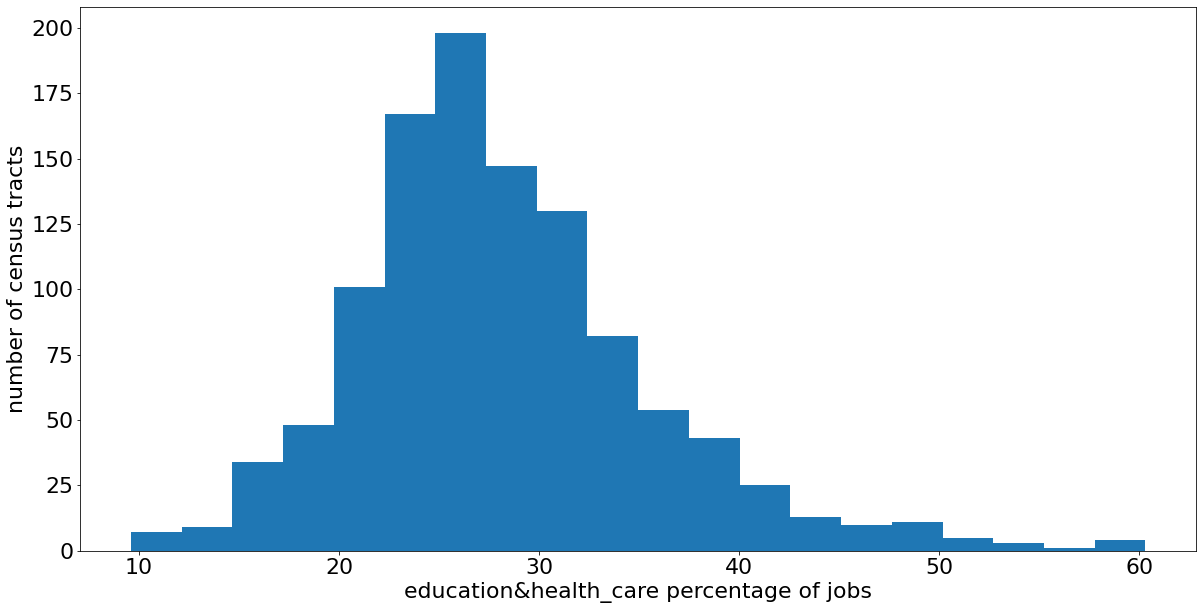

In [127]:
for column in ['STEM_jobs', 'education&health_care']:
    plt.figure(figsize=(20, 10))
    plt.hist(occupation_df[column], bins=20)
    plt.xlabel(column + ' percentage of jobs')
    plt.ylabel('number of census tracts')
    plt.show()

In [128]:
ct_stats_df = ct_stats_df.merge(occupation_df, on='ct_key', how='left')

### Household size

In [129]:
# HOUSEHOLDS AND FAMILIES
household_size_df = read_in_dataset('household_size')

In [130]:
column_to_new_column = {
    'Estimate!!Total!!HOUSEHOLDS!!Total households': 'total_households',
    'Estimate!!Total!!FAMILIES!!Average family size': 'avg_family_size',
    'Estimate!!Married-couple family household!!HOUSEHOLDS!!Average household size': 'avg_married_family_size',
    'Estimate!!Nonfamily household!!HOUSEHOLDS!!Average household size': 'avg_nonfamily_size',
    'Estimate!!Total!!HOUSEHOLDS!!Average household size': 'avg_household_size'
}

In [131]:
household_size_df = household_size_df[['ct_key'] + list(column_to_new_column)]
household_size_df.rename(column_to_new_column, axis=1, inplace=True)

In [132]:
household_size_df[(household_size_df['avg_family_size'] == '-') | 
                  (household_size_df['avg_married_family_size'] == '-') |
                  (household_size_df['avg_nonfamily_size'] == '-') |
                  (household_size_df['avg_household_size'] == '-')]

,ct_key,total_households,avg_family_size,avg_married_family_size,avg_nonfamily_size,avg_household_size
44,25001014300,1692,2.82,2.87,-,2.33
771,25017358600,2066,3.35,3.4,-,2.9
852,25017384001,538,3.33,3.29,-,2.76
889,25021403100,2262,3.39,3.46,-,3.03
915,25021412200,1444,3.36,3.37,-,2.73
987,25021442103,2341,3.45,3.53,-,3.14
1000,25021457200,2203,3.23,3.25,-,2.73
1070,25023525300,3,-,-,-,-
1203,25025090300,1239,3.86,5.27,-,2.8
1235,25025101101,1124,3.78,4.26,-,3.42


In [133]:
for idx, row in household_size_df.iterrows():
    for column in ['avg_family_size', 'avg_married_family_size', 'avg_household_size']:
        if row[column] == '-':
            mean_val = np.mean([float(x) for x in household_size_df[column] if x != '-'])
            household_size_df.loc[idx, column] = mean_val
        if row['avg_nonfamily_size'] == '-':
            try:
                impute_val = 2 * float(row['avg_household_size']) - float(row['avg_family_size'])
            except ValueError:
                mean_avg_household_size = np.mean([float(x) for x in household_size_df['avg_household_size']
                                                   if x != '-'])
                mean_avg_family_size = np.mean([float(x) for x in household_size_df['avg_family_size']
                                                    if x != '-'])
                impute_val = 2 * mean_avg_household_size - mean_avg_family_size
            household_size_df.loc[idx, 'avg_nonfamily_size'] = impute_val

In [134]:
for column in list(column_to_new_column.values())[1:]:
    household_size_df[column] = household_size_df[column].astype(float)

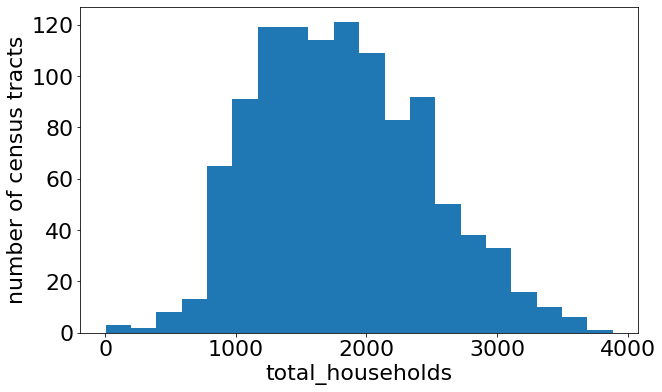

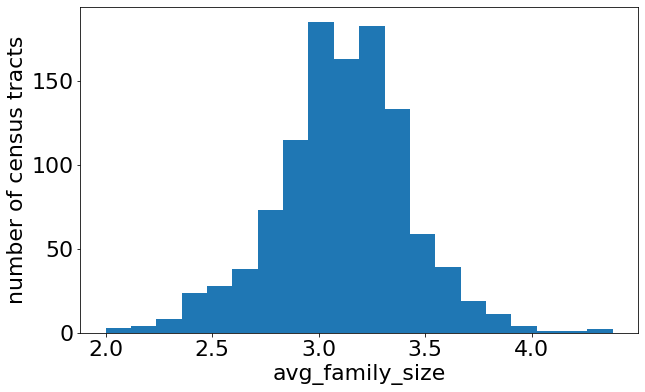

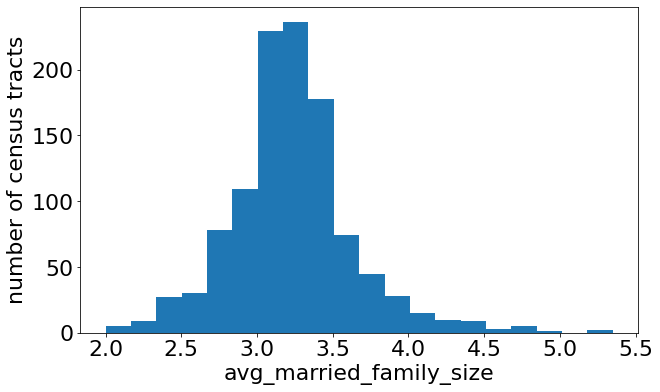

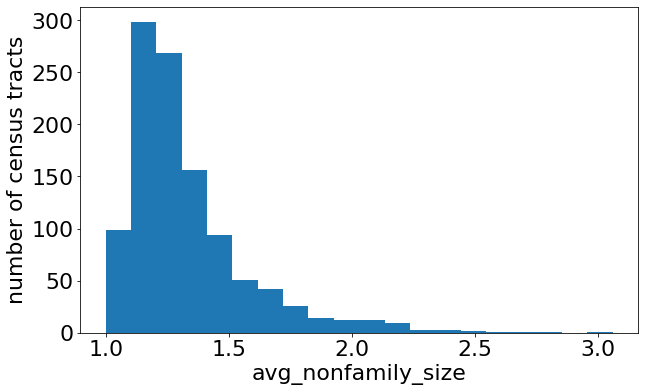

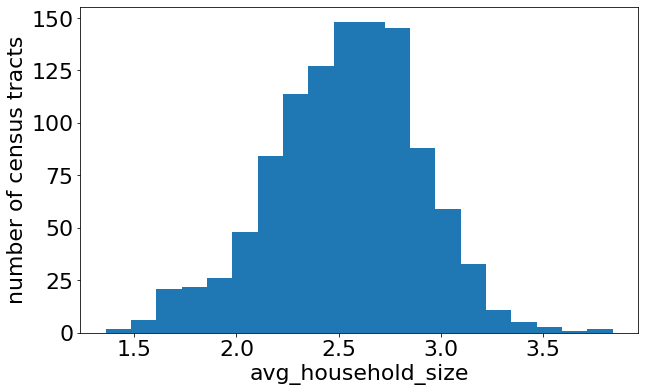

In [135]:
for column in household_size_df.columns:
    if column != 'ct_key':
        plt.figure(figsize=(10, 6))
        plt.hist(household_size_df[column], bins=20)
        plt.xlabel(column)
        plt.ylabel('number of census tracts')
        plt.show()

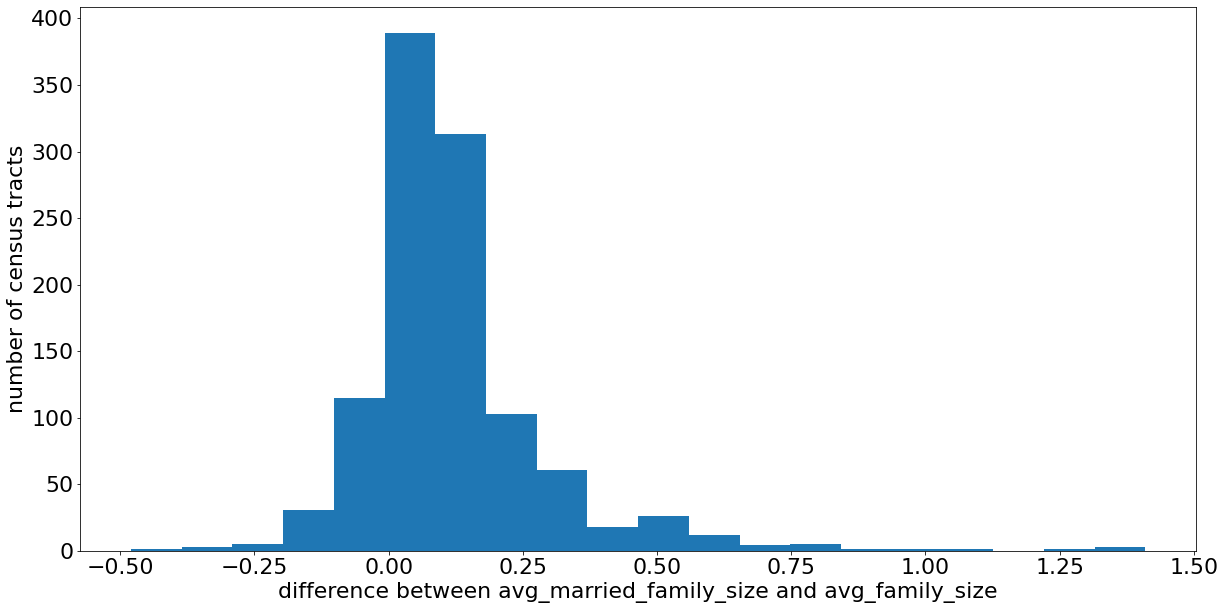

In [136]:
plt.figure(figsize=(20, 10))
plt.hist(household_size_df['avg_married_family_size'] - household_size_df['avg_family_size'], bins=20)
plt.xlabel('difference between avg_married_family_size and avg_family_size')
plt.ylabel('number of census tracts')
plt.show()

In [137]:
household_size_df.drop('avg_married_family_size', axis=1, inplace=True, errors='ignore')

In [138]:
ct_stats_df = ct_stats_df.merge(household_size_df, on='ct_key', how='left')

### Home Value

In [139]:
# VALUE (2018: ACS 5-Year Estimates Detailed Tables)
# https://data.census.gov/cedsci/table?t=Housing&g=0400000US08.140000&tid=ACSDT5Y2018.B25075&hidePreview=false
valuation_df = read_in_dataset('house_value')

Home price brackets:
1. `<200k`
2. `200-300k`
3. `300-400k`
3. `400-500k`
4. `500-750k`
5. `750k-1000k`
6. `>1M`

In [140]:
value_bracket_to_column_endings = {
    '<200k': ['$80,000 to $89,999', '$90,000 to $99,999', '$100,000 to $124,999', '$125,000 to $149,999',
              '$150,000 to $174,999', '$175,000 to $199,999'],
    '200-300k': ['$200,000 to $249,999', '$250,000 to $299,999'],
    '300-400k': ['$300,000 to $399,999'],
    '400-500k': ['$400,000 to $499,999'],
    '500-750k': ['$500,000 to $749,999'],
    '750-1000k': ['$750,000 to $999,999'],
    '>1M': ['$1,000,000 to $1,499,999', '$1,500,000 to $1,999,999', '$2,000,000 or more']
}

In [141]:
valuation_breakdown_df = pd.DataFrame(valuation_df['ct_key'])

In [142]:
columns_to_subtract = ['Less than $10,000', '$10,000 to $14,999', '$15,000 to $19,999', '$20,000 to $24,999',
                       '$25,000 to $29,999', '$30,000 to $34,999', '$35,000 to $39,999', '$40,000 to $49,999',
                       '$50,000 to $59,999', '$60,000 to $69,999', '$70,000 to $79,999']
total_homes = np.array(valuation_df['Estimate!!Total'])
for column in columns_to_subtract:
    total_homes -= np.array(valuation_df['Estimate!!Total!!' + column])
    
valuation_breakdown_df['total_homes'] = total_homes

In [143]:
for value_bracket, column_endings in value_bracket_to_column_endings.items():
    cnt_array = np.zeros(len(valuation_breakdown_df))
    for column_ending in column_endings:
        relevant_column = [column for column in valuation_df.columns
                           if column == 'Estimate!!Total!!' + column_ending][0]
        cnt_array += valuation_df[relevant_column]
    valuation_breakdown_df[value_bracket] = cnt_array / valuation_breakdown_df['total_homes']

In [144]:
valuation_breakdown_df.head() 

,ct_key,total_homes,<200k,200-300k,300-400k,400-500k,500-750k,750-1000k,>1M
0,25025060501,1031,0.0,0.055286,0.087294,0.201746,0.404462,0.101843,0.149370
1,25025061101,8,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2,25025070101,1069,0.0,0.078578,0.065482,0.030870,0.163704,0.206735,0.454630
3,25025070402,41,0.0,0.121951,0.000000,0.000000,0.146341,0.121951,0.609756
4,25025071101,811,0.0,0.038224,0.102343,0.086313,0.258940,0.438964,0.075216


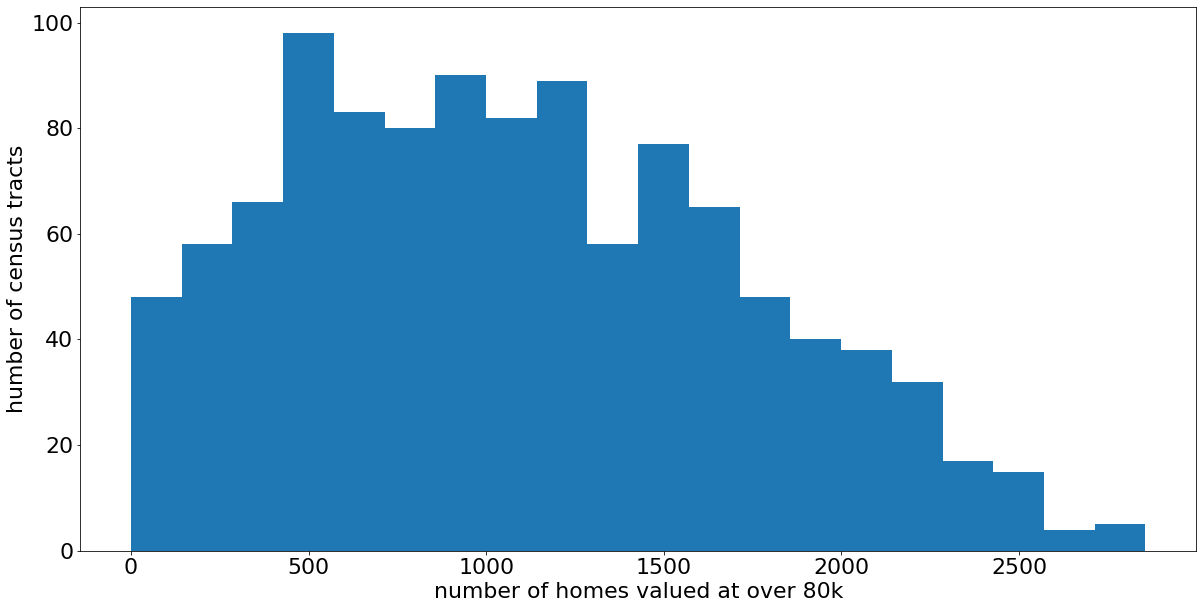

In [145]:
plt.figure(figsize=(20, 10))
plt.hist(valuation_breakdown_df['total_homes'], bins=20)
plt.xlabel('number of homes valued at over 80k')
plt.ylabel('humber of census tracts')
plt.show()

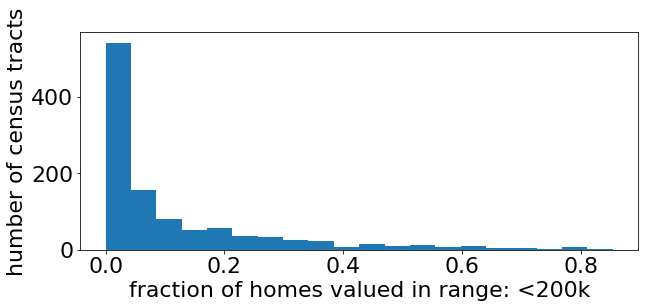

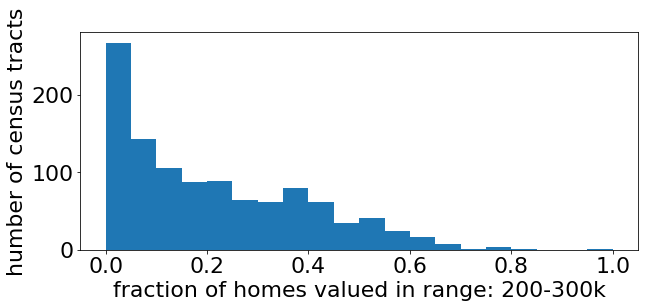

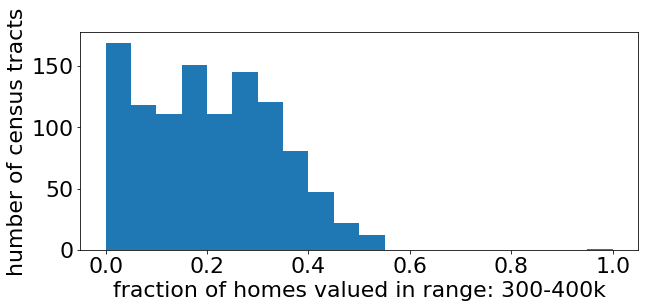

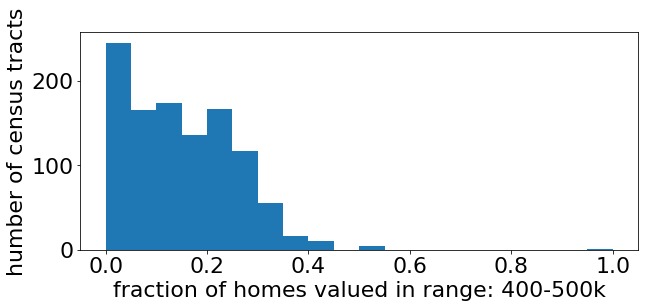

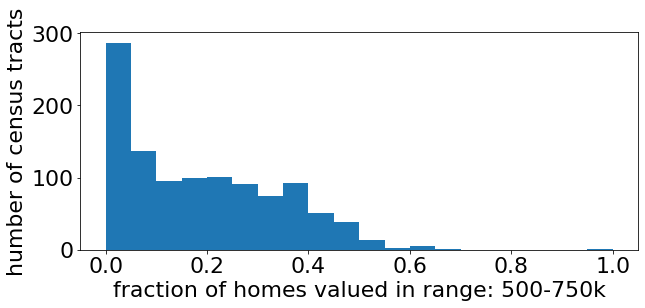

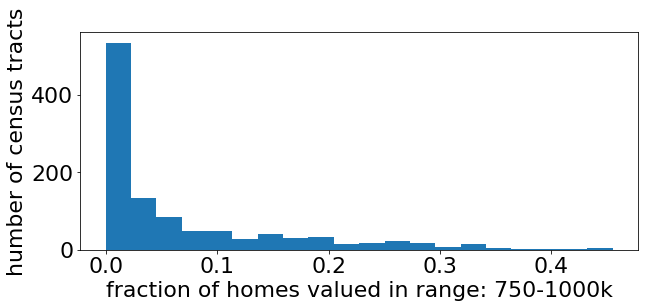

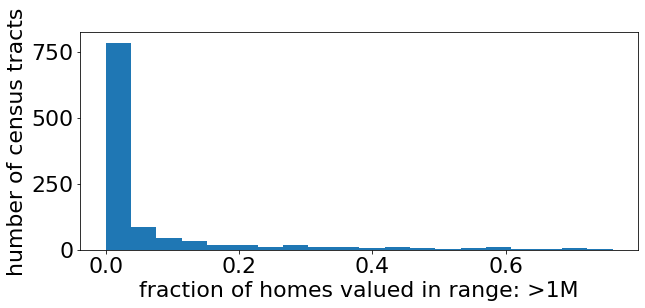

In [146]:
for column in valuation_breakdown_df.columns:
    if column not in {'ct_key', 'total_homes'}:
        plt.figure(figsize=(10, 4))
        plt.hist(valuation_breakdown_df[column], bins=20)
        plt.xlabel(f'fraction of homes valued in range: {column}')
        plt.ylabel('humber of census tracts')
        plt.show()

In [147]:
valuation_breakdown_df[valuation_breakdown_df['total_homes'] < 100]

,ct_key,total_homes,<200k,200-300k,300-400k,400-500k,500-750k,750-1000k,>1M
1,25025061101,8,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
3,25025070402,41,0.000000,0.121951,0.000000,0.000000,0.146341,0.121951,0.609756
21,25027710700,74,0.729730,0.121622,0.148649,0.000000,0.000000,0.000000,0.000000
31,25027732500,67,0.417910,0.507463,0.000000,0.000000,0.000000,0.074627,0.000000
45,25027732001,40,0.275000,0.725000,0.000000,0.000000,0.000000,0.000000,0.000000
110,25025080601,67,0.074627,0.432836,0.373134,0.104478,0.014925,0.000000,0.000000
165,25005641000,42,0.000000,0.547619,0.190476,0.000000,0.000000,0.000000,0.261905
366,25017360100,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
742,25025060700,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
770,25005651200,82,0.621951,0.378049,0.000000,0.000000,0.000000,0.000000,0.000000


In [148]:
valuation_breakdown_df.drop('total_homes', axis=1, inplace=True, errors='ignore')
ct_stats_df = ct_stats_df.merge(valuation_breakdown_df, on='ct_key', how='left')

### Marital Status

In [149]:
# MARITAL STATUS
marital_status_df = read_in_dataset('marital_status')

In [150]:
relationship_status_to_categories = {'married': ['Now married'],
                                     'divorced/separated/widowed': ['Widowed', 'Divorced', 'Separated'],
                                     'never_married': ['Never married']}

In [151]:
relationship_status_df = pd.DataFrame(marital_status_df['ct_key'])

In [152]:
for relationship_status, categories in relationship_status_to_categories.items():
    percent_array = np.zeros(len(relationship_status_df))
    for category in categories:
        relevant_column = [column for column in marital_status_df.columns
                           if column.startswith('Estimate!!' + category)][0]
        percent_array += marital_status_df[relevant_column].astype(float)
    relationship_status_df[relationship_status] = percent_array 

In [153]:
relationship_status_df.head()

,ct_key,married,divorced/separated/widowed,never_married
0,25001010100,42.2,20.9,36.9
1,25001010206,43.0,17.9,39.1
2,25001010208,65.2,21.2,13.5
3,25001010304,59.4,18.4,22.2
4,25001010306,61.0,19.6,19.4


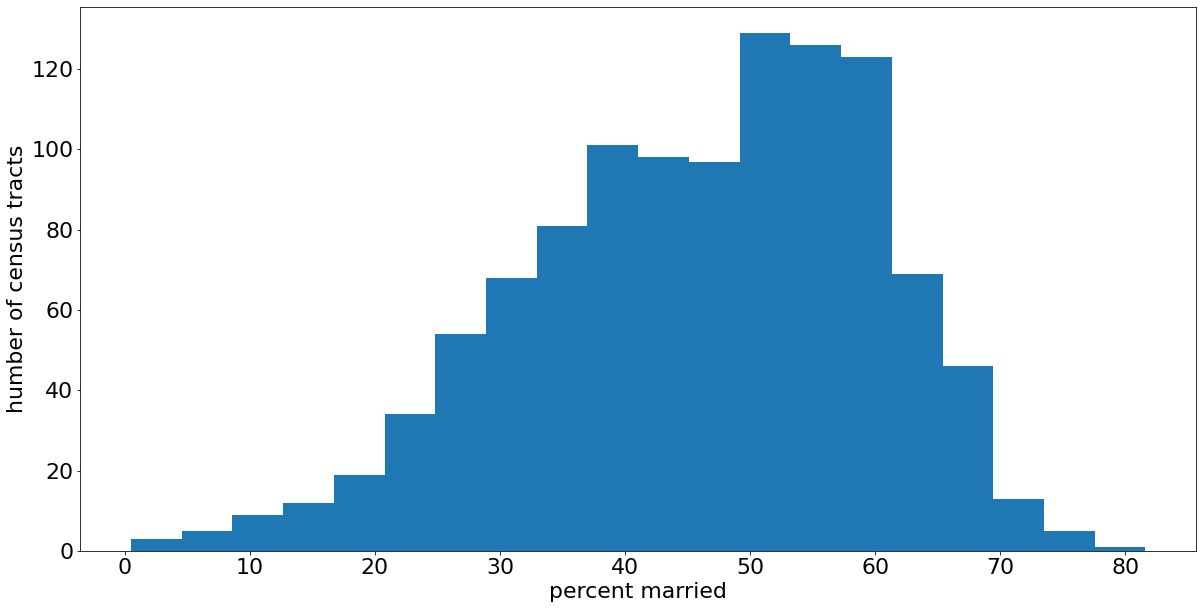

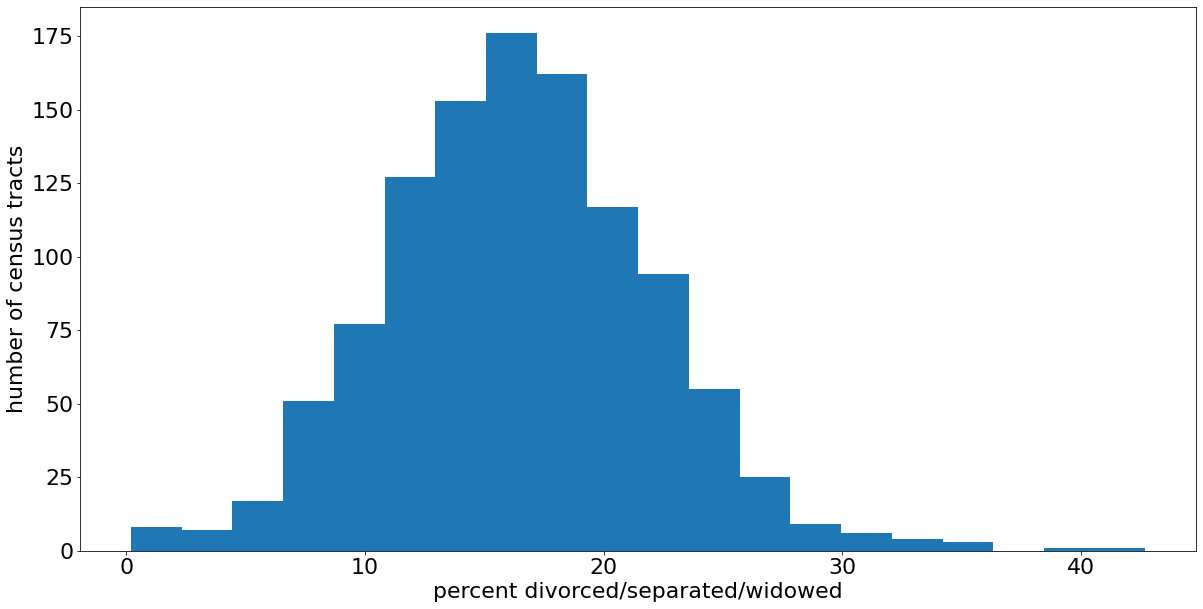

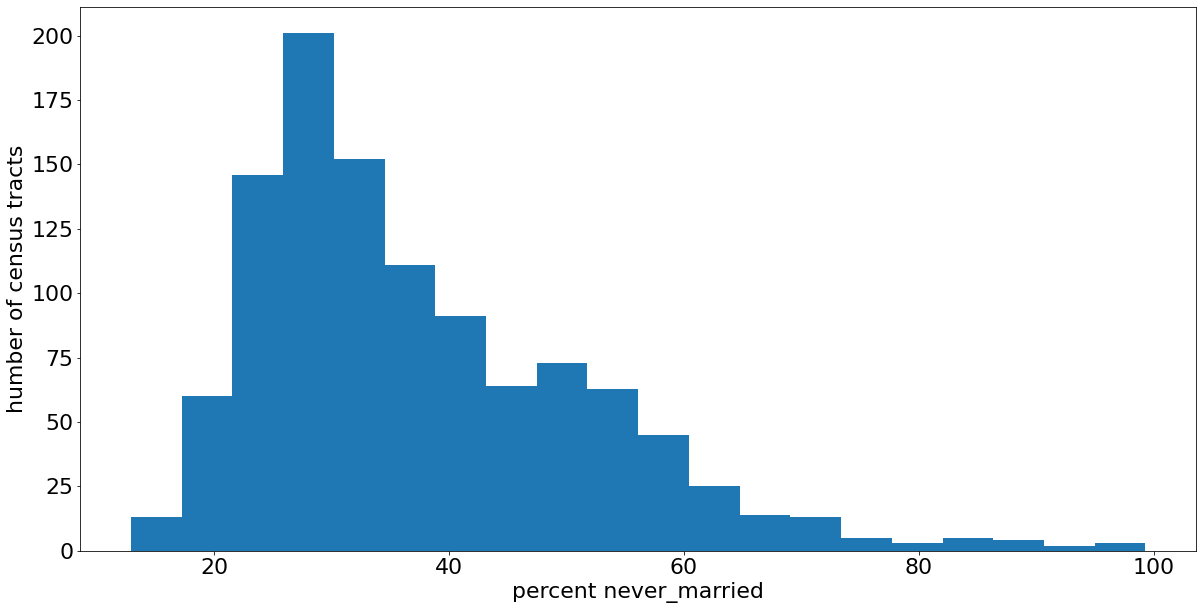

In [154]:
for column in relationship_status_df.columns:
    if column != 'ct_key':
        plt.figure(figsize=(20, 10))
        plt.hist(relationship_status_df[column], bins=20)
        plt.xlabel(f'percent {column}')
        plt.ylabel('humber of census tracts')
        plt.show()

In [155]:
ct_stats_df = ct_stats_df.merge(relationship_status_df, on='ct_key', how='left')

### Mortgage

In [156]:
# MORTGAGE STATUS
# https://data.census.gov/cedsci/table?q=ACSDT1Y2019.B25081&g=0400000US08.140000&tid=ACSDT5Y2018.B25081&hidePreview=true
mortgage_status_df = read_in_dataset('mortgage_status')

In [157]:
mortgage_status_df.head(2)

,ct_key,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,"Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt","Margin of Error!!Total!!Housing units with a mortgage, contract to purchase, or similar debt","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both","Margin of Error!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both!!Second mortgage only","Margin of Error!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both!!Second mortgage only","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both!!Home equity loan only","Margin of Error!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both!!Home equity loan only","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!Both second mortgage and home equity loan","Margin of Error!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!Both second mortgage and home equity loan","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!No second mortgage and no home equity loan","Margin of Error!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!No second mortgage and no home equity loan",Estimate!!Total!!Housing units without a mortgage,Margin of Error!!Total!!Housing units without a mortgage
0,25025060501,"Census Tract 605.01, Suffolk County, Massachus...",1042,169,922,172,206,90,40,46,166,82,29,32,687,168,120,65
1,25025061101,"Census Tract 611.01, Suffolk County, Massachus...",8,13,8,13,0,12,0,12,0,12,0,12,8,13,0,12


In [158]:
column_to_new_column = {
    'Estimate!!Total': 'house_num',
    'Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt': 'mortgage_num',
    'Estimate!!Total!!Housing units without a mortgage': 'no_mortgage_num'
}

In [159]:
mortgage_info_df = mortgage_status_df[['ct_key'] + list(column_to_new_column)]
mortgage_info_df.rename(column_to_new_column, axis=1, inplace=True)

In [160]:
for column in ['mortgage_num', 'no_mortgage_num']:
    new_column = 'percent_' + '_'.join(column.split('_')[:-1])
    mortgage_info_df[new_column] = mortgage_info_df[column] / mortgage_info_df['house_num']

mortgage_info_df.drop(column_to_new_column.values(), axis=1, inplace=True, errors='ignore')

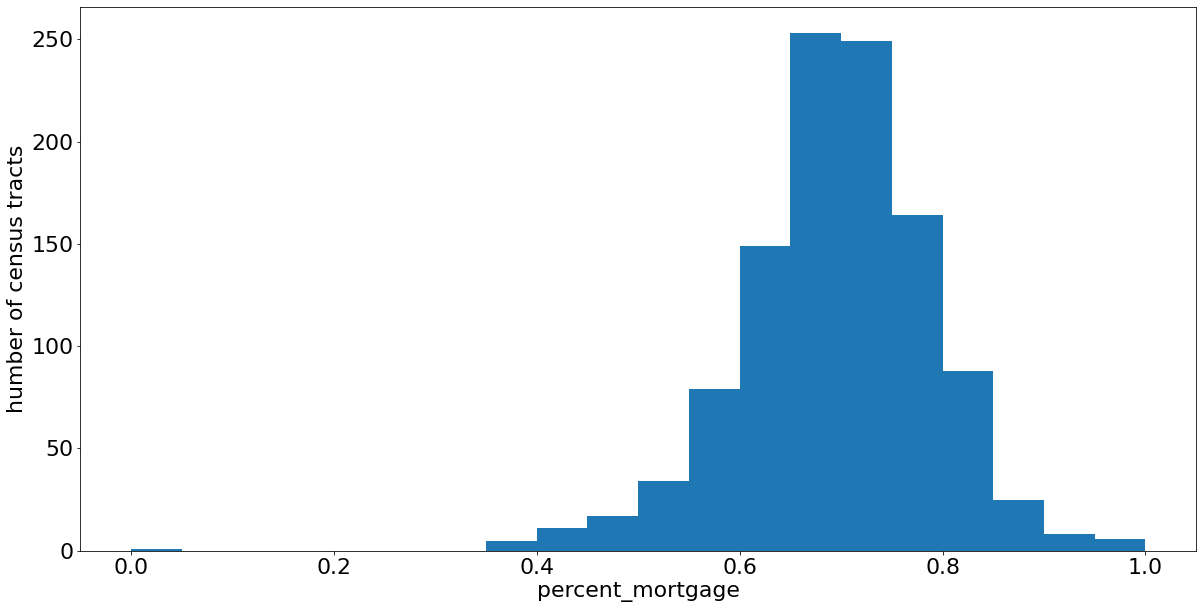

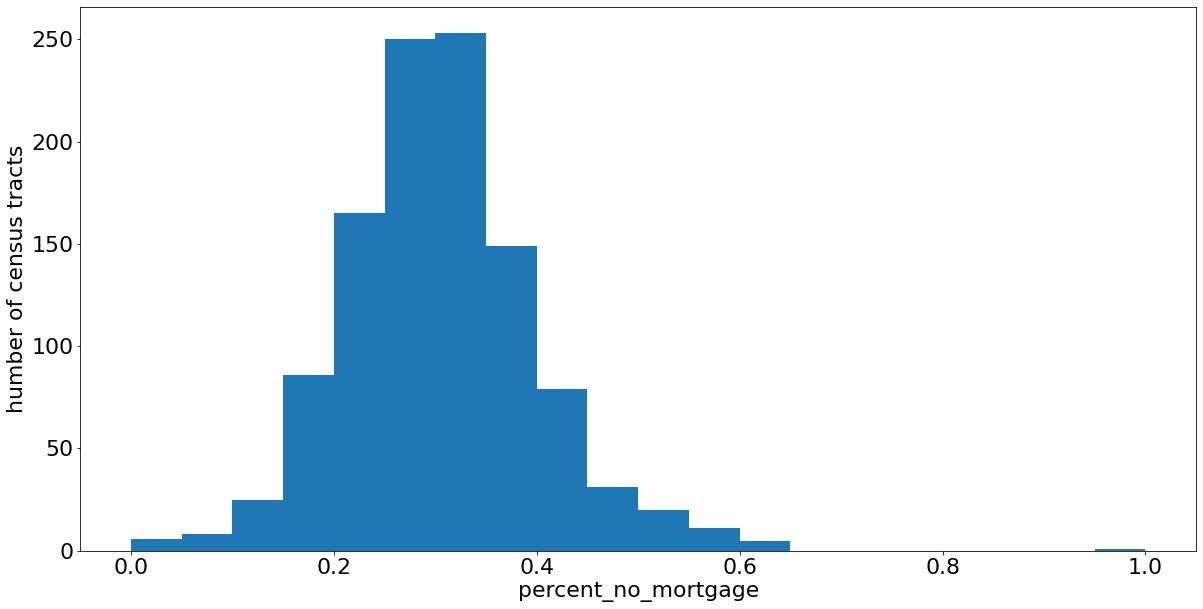

In [161]:
for column in mortgage_info_df.columns:
    if column != 'ct_key':
        plt.figure(figsize=(20, 10))
        plt.hist(mortgage_info_df[column], bins=20)
        plt.xlabel(column)
        plt.ylabel('humber of census tracts')
        plt.show()

In [162]:
# FINANCIAL CHARACTERISTICS FOR HOUSING UNITS WITH A MORTGAGE
mortgage_amount_df = read_in_dataset('mortgage_amount')

In [163]:
col = 'Estimate!!Owner-occupied housing units with a mortgage!!Owner-occupied housing units with a mortgage!!VALUE!!Median (dollars)'
mortgage_amount_df.rename(columns={col: 'median_mortgage_value'}, inplace=True)

In [164]:
mortgage_info_df = mortgage_info_df.merge(mortgage_amount_df[['ct_key', 'median_mortgage_value']],
                                          on='ct_key', how='left')

In [165]:
mortgage_info_df[(mortgage_info_df['median_mortgage_value'] == '-') |
                  mortgage_info_df['percent_mortgage'].isna() |
                  mortgage_info_df['percent_no_mortgage'].isna()]

,ct_key,percent_mortgage,percent_no_mortgage,median_mortgage_value
1,25025061101,1.000000,0.000000,-
11,25027731400,0.429348,0.570652,-
12,25027731600,0.423469,0.576531,-
130,25005641000,0.569231,0.430769,-
222,25017360100,NaN,NaN,-
509,25025060700,NaN,NaN,-
638,25025080801,NaN,NaN,-
640,25025090901,0.000000,1.000000,-
741,25017353102,NaN,NaN,-
797,25025000703,0.363636,0.636364,-


In [166]:
mean_median_mortgage_value = np.mean([int(x) for x in mortgage_info_df['median_mortgage_value'] if x != '-'])
mortgage_info_df['median_mortgage_value'] = [int(x) if x != '-' else mean_median_mortgage_value
                                             for x in mortgage_info_df['median_mortgage_value']]


for column in ['percent_mortgage', 'percent_no_mortgage']:
    mean_val = np.mean(mortgage_info_df[column])
    mortgage_info_df[column] = [x if pd.notnull(x) else mean_val
                                for x in mortgage_info_df[column]]

In [167]:
mortgage_info_df[(mortgage_info_df['median_mortgage_value'] == '-') |
                  mortgage_info_df['percent_mortgage'].isna() |
                  mortgage_info_df['percent_no_mortgage'].isna()]

,ct_key,percent_mortgage,percent_no_mortgage,median_mortgage_value


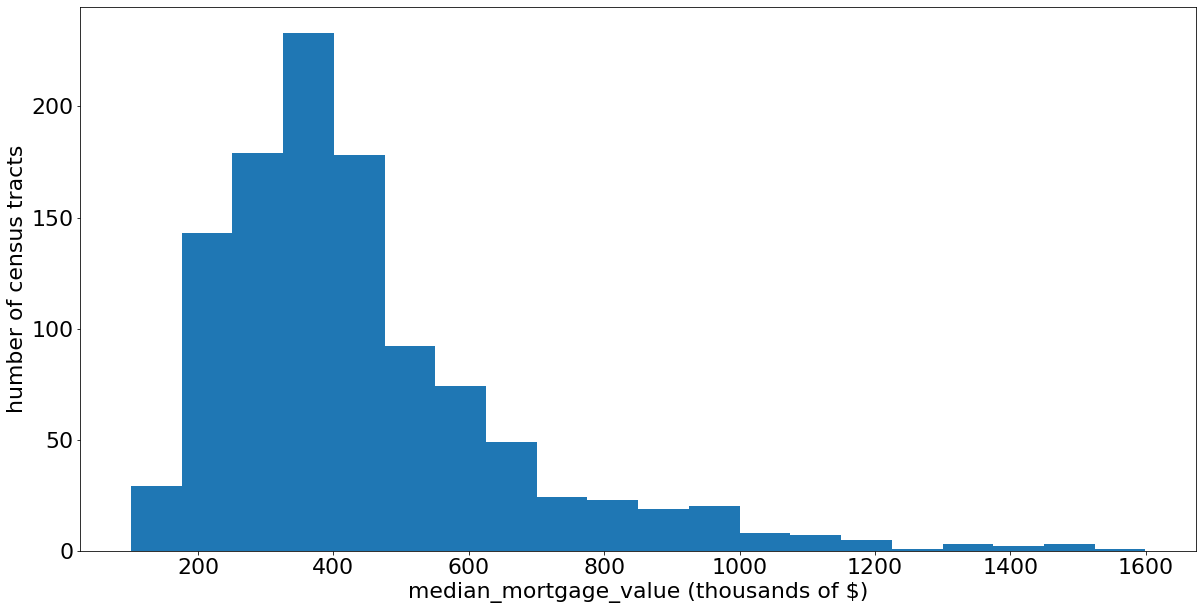

In [168]:
plt.figure(figsize=(20, 10))
plt.hist(mortgage_info_df['median_mortgage_value'] / 1000, bins=20)
plt.xlabel('median_mortgage_value (thousands of $)')
plt.ylabel('humber of census tracts')
plt.show()

In [169]:
ct_stats_df = ct_stats_df.merge(mortgage_info_df, on='ct_key', how='left')

### Age of homes

In [170]:
# YEAR STRUCTURE BUILT
year_built_df = read_in_dataset('year_built')

In [171]:
column_to_new_column = {'2014 or later': '2014 or later',
                        '2010 to 2013': '2010-2013',
                        '2000 to 2009': '2000-2009'}

column_to_new_column = {'Estimate!!Total!!Built ' + column: 'built ' + new_column
                        for column, new_column in column_to_new_column.items()}

column_to_new_column['Estimate!!Total'] = 'total_households'

In [172]:
year_built_df = year_built_df[['ct_key'] + list(column_to_new_column)]
year_built_df.rename(column_to_new_column, axis=1, inplace=True)

In [173]:
for column in column_to_new_column.values():
    if column != 'total_households':
        year_built_df[column] = year_built_df[column] / year_built_df['total_households']

year_built_df.drop(columns=['total_households'], inplace=True)

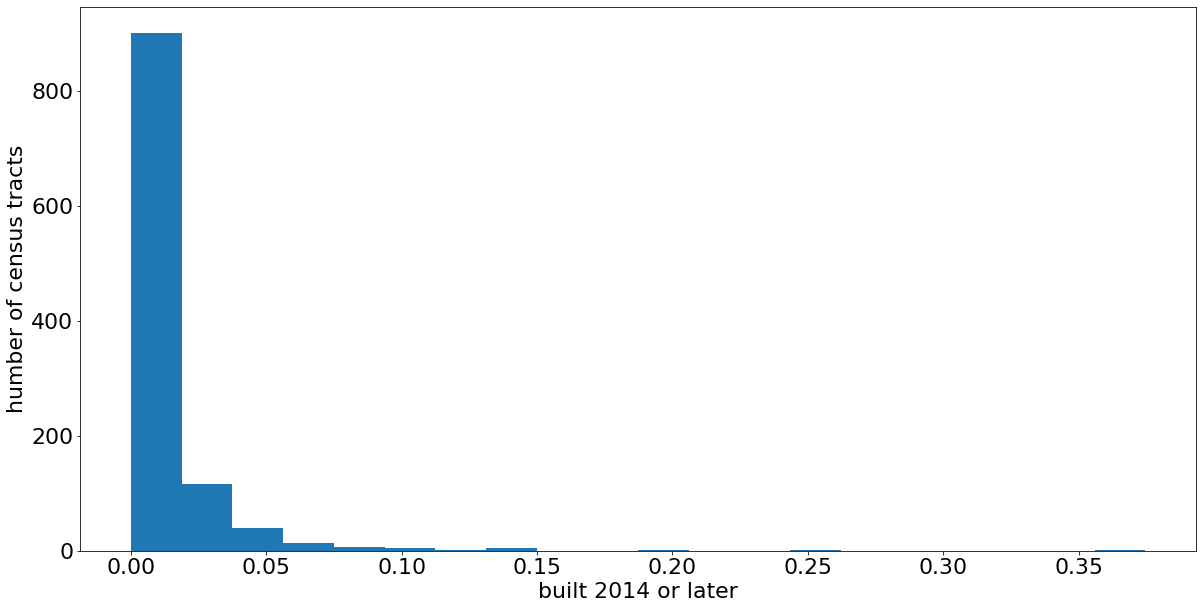

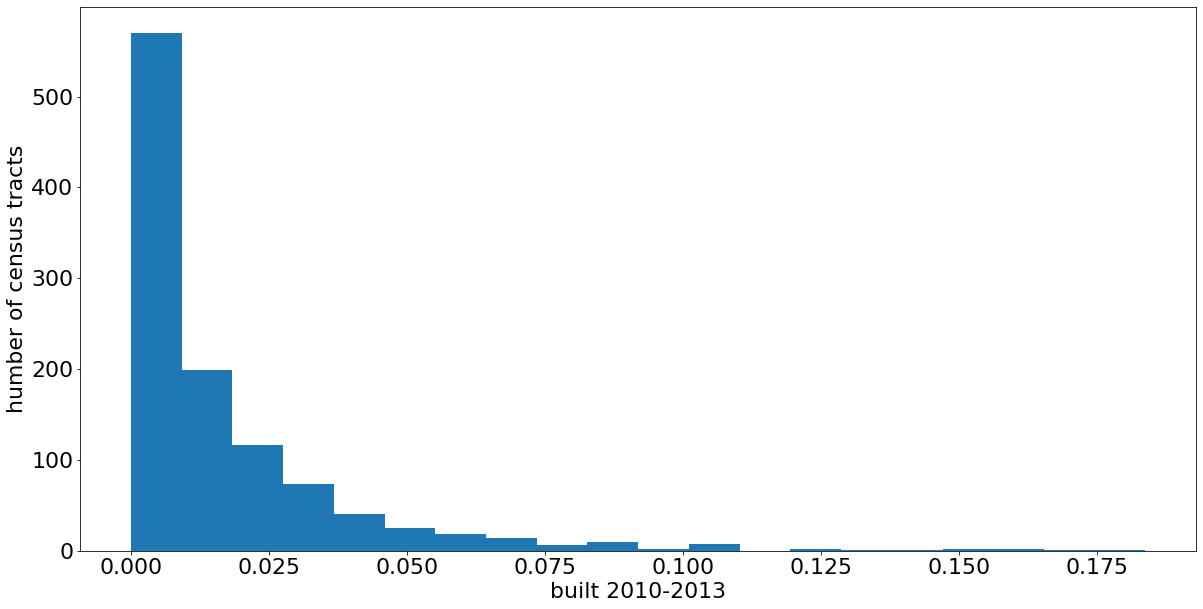

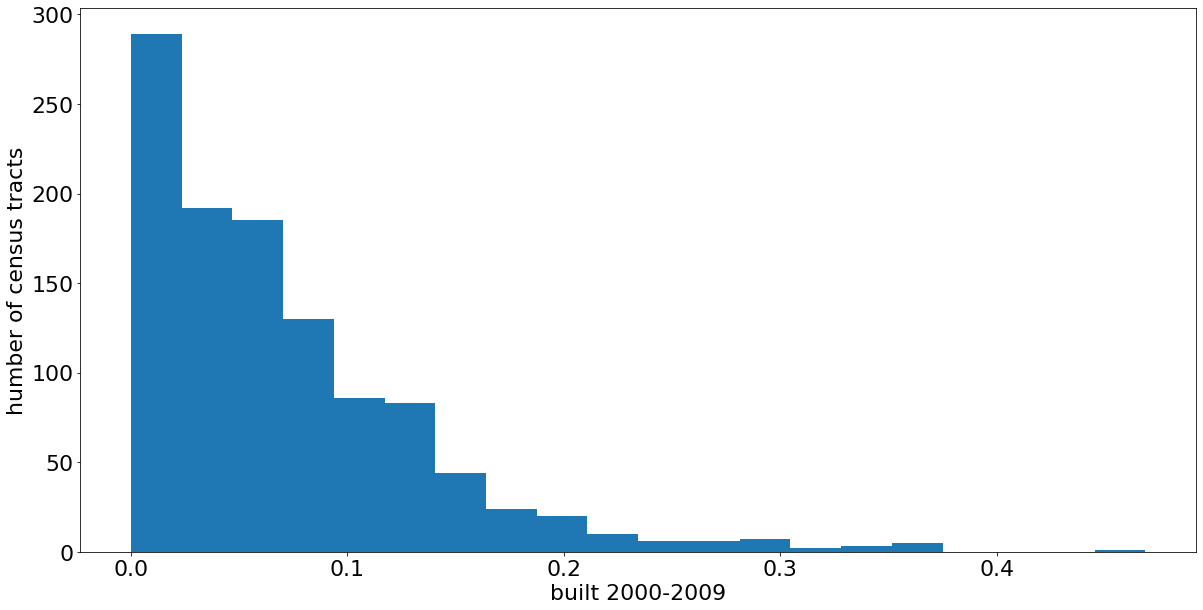

In [174]:
for column in year_built_df.columns:
    if column != 'ct_key':
        plt.figure(figsize=(20, 10))
        plt.hist(year_built_df[column], bins=20)
        plt.xlabel(column)
        plt.ylabel('humber of census tracts')
        plt.show()

In [175]:
ct_stats_df = ct_stats_df.merge(year_built_df, on='ct_key', how='left')

### Clean census-tract data

In [176]:
my_column_start = list(ct_stats_df.columns).index('census_population')
my_columns = ct_stats_df.columns[my_column_start:]
all_outlier_census_tracts = []
for column in my_columns:
    lower_extreme, upper_extreme = np.quantile(ct_stats_df[column], [0.02, 0.98])
    outlier_census_tracts = ct_stats_df[(ct_stats_df[column] <= lower_extreme) | 
                                        (ct_stats_df[column] >= upper_extreme)]['ct_key']
    all_outlier_census_tracts.extend(outlier_census_tracts) 

In [177]:
census_tracts_ranked = Counter(all_outlier_census_tracts).most_common(50)
worst_census_tracts = [x[0] for x in census_tracts_ranked]

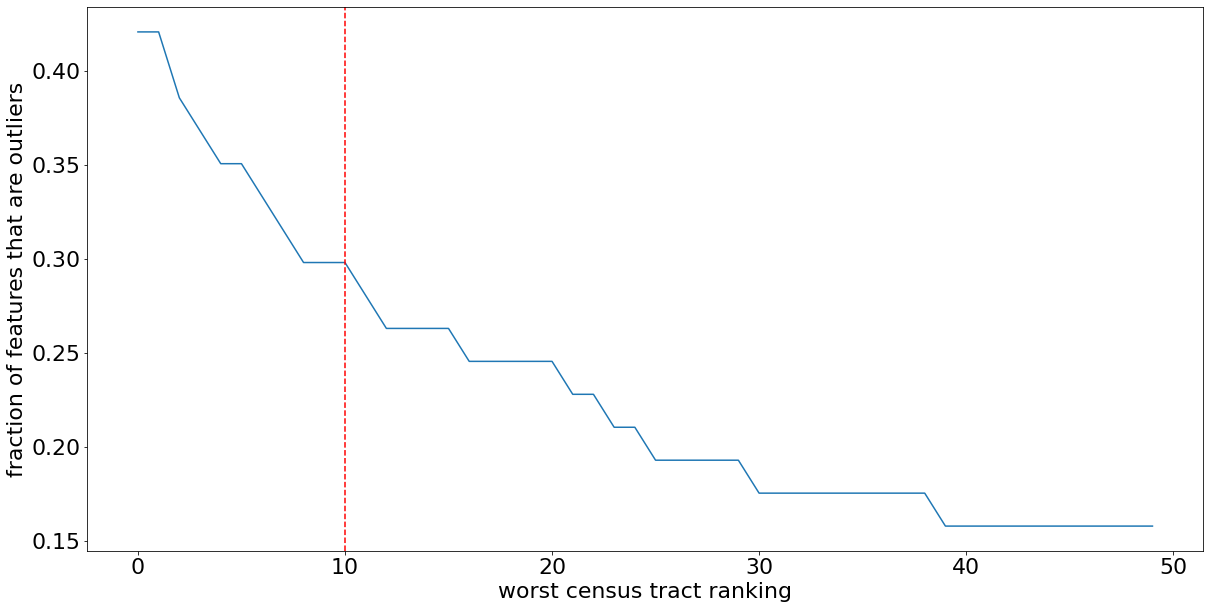

In [178]:
outlier_num_lst = [x[1] / len(my_columns) for x in census_tracts_ranked]
plt.figure(figsize=(20, 10))
plt.plot(outlier_num_lst)
plt.xlabel('worst census tract ranking')
plt.ylabel('fraction of features that are outliers')
plt.axvline(x=10, color='r', linestyle='--')
plt.show()

In [179]:
neighborhoood_scout_columns_to_new_columns = {
    'rent.ct': 'median_rental_price',
    'grrent_yield.ct': 'average_annual_rent_as_percentage_of_property_value',
    'frm.ct': 'farm_score',
    'pop_density.ct': 'pop_density',
    'den.ct': 'densely_urban_score',
    'urb.ct': 'urban_score',
    'sub.ct': 'suburban_score',
    'rur.ct': 'rural_score',
    'rmt.ct': 'remote_score',
    'new_pct.ct': 'built 1995 or later',
    'est_pct.ct': 'built 1970-1994',
    'old_pct.ct': 'built 1940-1969',
    'his_pct.ct': 'built before 1940',
    'det_pct.ct': 'single_family_detached_pct',
    'att_pct.ct': 'rowhouses_and_attached_homes_pct',
    'sap_pct.ct': 'small_apt_buildings_pct',
    'lap_pct.ct': 'complexes/high_rise_apt_pct',
    'mob_pct.ct': 'mobile_home_pct',
    'bed0_pct.ct': '0_bedroom_pct',
    'bed1_pct.ct': '1_bedroom_pct',
    'bed2_pct.ct': '2_bedroom_pct',
    'bed3_pct.ct': '3_bedroom_pct',
    'bed4_pct.ct': '4_bedroom_pct',
    'bed5_pct.ct': '5_bedroom_pct',
    'own_pct.ct': 'homeownership_rate',
    'rnt_pct.ct': 'rental_rate',
    'seasonal_pct.ct': 'seasonal_housing_pct',
    'vacant_pct.ct': 'vacant_homes_pct',
    'family_fr.ct': 'family_friendly_score',
    'ft_homebuyer.ct': 'first_time_homebuyer_score',
    'luxury.ct': 'luxury_communities_score',
    'retire_fr.ct': 'retirement_friendly_score',
    'young_sng_pro.ct': 'young_single_professional_score',
    'college_fr.ct': 'college_student_friendly_score',
    'commtime15_pct.ct': 'commute_under_15_min_pct',
    'commtime30_pct.ct': 'commute_15-30_min_pct',
    'commtime45_pct.ct': 'commute_30-45_min_pct',
    'commtime60_pct.ct': 'commute_45-60_min_pct',
    'commtime90_pct.ct': 'commute_over_60_min_pct',
    'pt_violent.ct': 'violent_crime_rate',
    'pt_property.ct': 'property_crime_rate',
    'education_score.ct': 'standardized_test_score_percentile',
    'college_grads.ct': 'pct_pop_at_least_college_degree',
    'children_poverty.ct': 'children_poverty_pct',
    'puptch.sd': 'student_to_teacher_ratio_sd',
    'stcls_total.sd': 'state_index_total_achievement_sd',
    'uscls_total.sd': 'national_index_total_achievement_sd',
    'usrpct_total.sd': 'national_percentile_total_achievement_sd',
    'strpct_total.sd': 'state_percentile_total_achievement_sd',
    'avg_member.sd': 'average_number_of_students_per_school_sd',
    'member.sc': 'number_of_students_sc',
    'puptch.sc': 'student_to_teacher_ratio_sc',
    'stcls_total.sc': 'state_index_total_achievement_sc',
    'uscls_total.sc': 'national_index_total_achievement_sc',
    'usrpct_total.sc': 'national_percentile_total_achievement_sc',
    'strpct_total.sc': 'state_percentile_total_achievement_sc',
}

In [180]:
ct_stats_df.rename(neighborhoood_scout_columns_to_new_columns, axis=1, inplace=True)

In [181]:
list(ct_stats_df[(ct_stats_df['ct_key'].isin(worst_census_tracts[:30])) & 
                 (ct_stats_df['rental_rate'] > 90)]['ct_key'])

[25005641101,
 25005651800,
 25017353102,
 25017353900,
 25017360100,
 25023525300,
 25023561200,
 25025000502,
 25025000703,
 25025000803,
 25025010103,
 25025010204,
 25025010300,
 25025010404,
 25025010405,
 25025010408,
 25025060700,
 25025061101,
 25025080601,
 25025080801,
 25027732001,
 25027732902]

In [182]:
ct_stats_df[(ct_stats_df['ct_key'].isin(worst_census_tracts[:30])) & 
            (~ct_stats_df['ct_key'].isin(census_tracts_to_ignore))]

,ct_key,median_rental_price,average_annual_rent_as_percentage_of_property_value,rent_br3.ct,rent_br2.ct,rent_br1.ct,rent_br0.ct,cos.ct,lake.ct,farm_score,pop_density,densely_urban_score,urban_score,suburban_score,rural_score,remote_score,built 1995 or later,built 1970-1994,built 1940-1969,built before 1940,single_family_detached_pct,rowhouses_and_attached_homes_pct,small_apt_buildings_pct,complexes/high_rise_apt_pct,mobile_home_pct,oth_pct.ct,0_bedroom_pct,1_bedroom_pct,2_bedroom_pct,3_bedroom_pct,4_bedroom_pct,5_bedroom_pct,base_pct.ct,dorms_pct.ct,incarc_pct.ct,publichou_pct.ct,homeownership_rate,rental_rate,seasonal_housing_pct,vacant_homes_pct,family_friendly_score,first_time_homebuyer_score,luxury_communities_score,vac_home.ct,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,commute_under_15_min_pct,commute_15-30_min_pct,commute_30-45_min_pct,commute_45-60_min_pct,commute_over_60_min_pct,count_violent.ct,count_property.ct,count_total.ct,violent_crime_rate,property_crime_rate,pt_total.ct,standardized_test_score_percentile,pct_pop_at_least_college_degree,children_poverty_pct,leaid,student_to_teacher_ratio_sd,state_index_total_achievement_sd,national_index_total_achievement_sd,national_percentile_total_achievement_sd,state_percentile_total_achievement_sd,average_number_of_students_per_school_sd,number_of_students_sc,student_to_teacher_ratio_sc,state_index_total_achievement_sc,national_index_total_achievement_sc,national_percentile_total_achievement_sc,state_percentile_total_achievement_sc,census_population,<18,18-24,25-34,35-49,50-59,60-64,65-74,75+,Hispanic,White,Black,Asian,linear_pop_trend_since_2010,avg_annual_pop_change_since_2010,linear_pop_trend_since_2014,avg_annual_pop_change_since_2014,annual_births_per_resident,workforce_fraction,car,carpool,public_transportation,walk,WFH,other_mode_of_transit,median_household_income,median_family_income,median_nonfamily_income,mean_household_income,mean_family_income,mean_nonfamily_income,family_households_fraction,nonfamily_households_fraction,above_poverty_line,below_poverty_line,STEM_jobs,education&health_care,total_households,avg_family_size,avg_nonfamily_size,avg_household_size,<200k,200-300k,300-400k,400-500k,500-750k,750-1000k,>1M,married,divorced/separated/widowed,never_married,percent_mortgage,percent_no_mortgage,median_mortgage_value,built 2014 or later,built 2010-2013,built 2000-2009
2,25001010208,1479.0,4.285947,1876.0,1479.0,NaN,NaN,0.0,100.0,100.0,95.583524,85.0,65.0,15.0,5.0,15.0,14.115490,38.252368,27.589368,20.042774,87.748243,3.116407,5.346777,1.710969,2.077605,0.000000,3.330278,15.276505,20.776046,32.966697,21.020471,6.630003,0.0,0.000000,0.000000,0.000000,85.685246,14.314754,79.101742,80.415521,27.111001,100.000000,27.148606,2.346779,3.920922,57.473719,84.013858,44.632768,37.853107,11.299435,6.214689,0.000000,5.0,18.0,23.0,2.501251,9.004502,11.505753,68.356473,0.517593,0.000000,2511730.0,6.625000,4.0,8.0,72.128666,34.663342,106.000000,106.000000,6.625000,4.000000,7.000000,68.356473,37.271397,1254,0.105263,0.033493,0.010367,0.192982,0.093301,0.150718,0.317384,0.096491,0.008772,0.965710,0.021531,0.000000,-0.031786,-0.042544,-0.059379,-0.074883,0.000000,0.433014,0.558011,0.077348,0.000000,0.001842,0.348066,0.014733,65446.0,67477.0,37206.0,69789.0,84172.0,42554.0,0.647426,0.352574,92.5,7.6,14.1,22.8,641,2.410000,1.080000,1.950000,0.030853,0.128857,0.161525,0.246824,0.319419,0.072595,0.039927,65.2,21.2,13.5,0.451906,0.548094,5.252000e+05,0.005805,0.003972,0.131378
111,25005641101,854.0,5.552344,1351.0,1139.0,947.0,639.0,100.0,100.0,100.0,9659.355756,12.0,8.0,28.0,78.0,88.0,1.845638,19.630872,9.815436,68.708054,1.929530,0.000000,26.258389,71.812081,0.000000,0.000000,11.577181,53.187919,17.449664,13.422819,4.110738,0.251678,0.0,0.000000,0.000000,0.000000,7.789174,92.210826,0.000000,15.771812,91.613737,94.550074,62.886762,100.000000,78.782755,37.838268,27.091754,41.834862,29.357798,17.064220,11.743119,0.000000,15.0,32.0,47.0,8.7

In [183]:
# top 30 worse census tracts that have a rental rate that is above 90%
census_tracts_to_ignore = [
    25005641101, 25005651800, 25017353102, 25017353900, 25017360100, 25023525300, 25023561200, 25025000502,
    25025000703, 25025000803, 25025010103, 25025010204, 25025010300, 25025010404, 25025010405, 25025010408,
    25025060700, 25025061101, 25025080601, 25025080801, 25027732001, 25027732902
]

In [184]:
ct_stats_df_cleaned = ct_stats_df[~ct_stats_df['ct_key'].isin(census_tracts_to_ignore)]

In [185]:
ct_stats_df_cleaned.drop(columns=['rent_br3.ct', 'rent_br2.ct', 'rent_br1.ct', 'rent_br0.ct',
                                  'above_poverty_line', 'percent_no_mortgage'], inplace=True)

In [186]:
ct_stats_df_cleaned.isna().sum()

ct_key                                                 0
median_rental_price                                    3
average_annual_rent_as_percentage_of_property_value    6
cos.ct                                                 0
lake.ct                                                0
farm_score                                             0
pop_density                                            0
densely_urban_score                                    0
urban_score                                            0
suburban_score                                         0
rural_score                                            0
remote_score                                           0
built 1995 or later                                    0
built 1970-1994                                        0
built 1940-1969                                        0
built before 1940                                      0
single_family_detached_pct                             0
rowhouses_and_attached_homes_pc

In [187]:
columns_to_impute_mean = ['median_rental_price', 'average_annual_rent_as_percentage_of_property_value',
                          'count_violent.ct', 'count_property.ct', 'count_total.ct']

for column in columns_to_impute_mean:
    ct_stats_df_cleaned[column] = [x if pd.notnull(x) else np.mean(ct_stats_df_cleaned[column])
                                   for x in ct_stats_df_cleaned[column]]

In [188]:
ct_stats_df_cleaned[ct_stats_df_cleaned['<200k'].isna()][['ct_key', 'rental_rate']]

,ct_key,rental_rate


`13067030414` and `13089021813` are over 99% rent so we ignore them 

In [189]:
ct_stats_df.shape

(1093, 131)

In [190]:
ct_stats_df_cleaned.shape

(1071, 125)

In [191]:
ct_stats_df_cleaned.isna().sum()

ct_key                                                 0
median_rental_price                                    0
average_annual_rent_as_percentage_of_property_value    0
cos.ct                                                 0
lake.ct                                                0
farm_score                                             0
pop_density                                            0
densely_urban_score                                    0
urban_score                                            0
suburban_score                                         0
rural_score                                            0
remote_score                                           0
built 1995 or later                                    0
built 1970-1994                                        0
built 1940-1969                                        0
built before 1940                                      0
single_family_detached_pct                             0
rowhouses_and_attached_homes_pc

In [192]:
my_column_start = list(ct_stats_df_cleaned.columns).index('census_population')
neighborhood_scout_columns = list(ct_stats_df_cleaned.columns)[1:my_column_start]

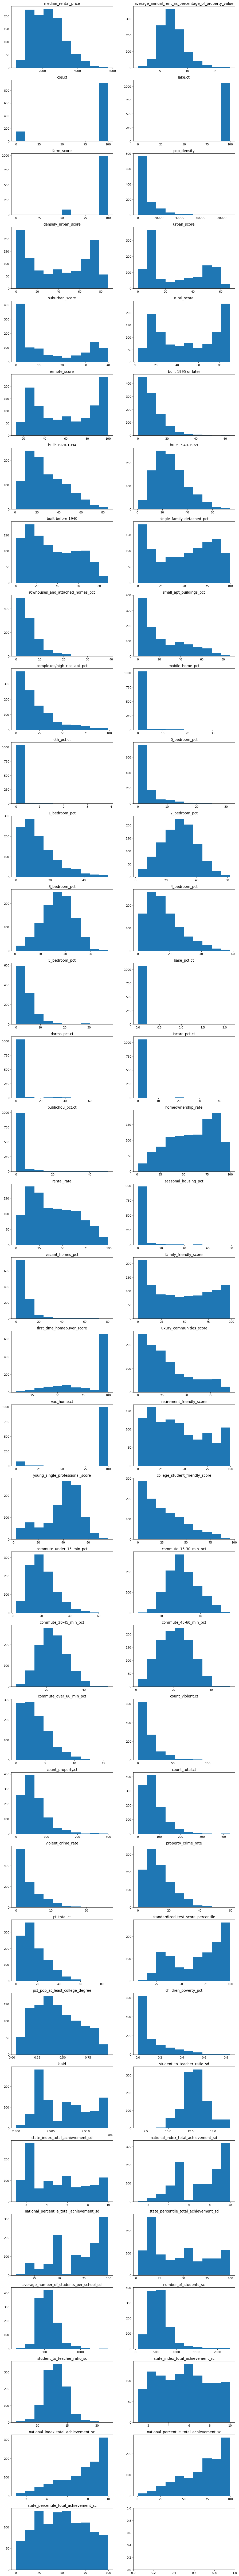

In [193]:
plt.rcParams.update({'font.size': 11})
fig, axs = plt.subplots(nrows=int(np.ceil(len(neighborhood_scout_columns) / 2)), ncols=2)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.subplots_adjust(bottom=-8)
cnt = 0
for column in neighborhood_scout_columns:
    
    row_idx = int(cnt / 2)
    col_idx = cnt % 2
    
    axs[row_idx, col_idx].hist(ct_stats_df_cleaned[column])
    axs[row_idx, col_idx].set_title(column)
    
    cnt += 1

plt.rcParams.update({'font.size': 22})

Neighborhood Scout columns to drop:

`cos.ct`: all census tracts have same score 

`lake.ct`: the vast majority of census tracts have the same score

`oth_pct.ct`: value is 0 for vast majority of census tracts and statistic doesn't tell us much

`base_pct.ct`: values is 0 except for one census tract

`dorms_pct.ct`: vast majority of values are 0

`incarc_pct.ct`: vast majority of values of 0

`publichou_pct.ct`: vast majority of values are 0

`vac_home.ct`: vatst majority of scores are 100

`count_violent.ct`: raw count that isn't normalized

`count_property.ct`: raw count that isn't normalized

`count_total.ct`: raw count that isn't normalized

`pt_total.ct`: already broken up into violent crime rate and property crime rate

`leaid`: meaningless

In [194]:
neighborhood_scout_columns_to_drop = [
    'cos.ct', 'lake.ct', 'oth_pct.ct', 'base_pct.ct', 'dorms_pct.ct', 'incarc_pct.ct', 'publichou_pct.ct',
    'vac_home.ct', 'count_violent.ct', 'count_property.ct', 'count_total.ct', 'pt_total.ct', 'leaid'
]
ct_stats_df_cleaned.drop(columns=neighborhood_scout_columns_to_drop, inplace=True)

In [195]:
ct_stats_df_cleaned.shape

(1071, 112)

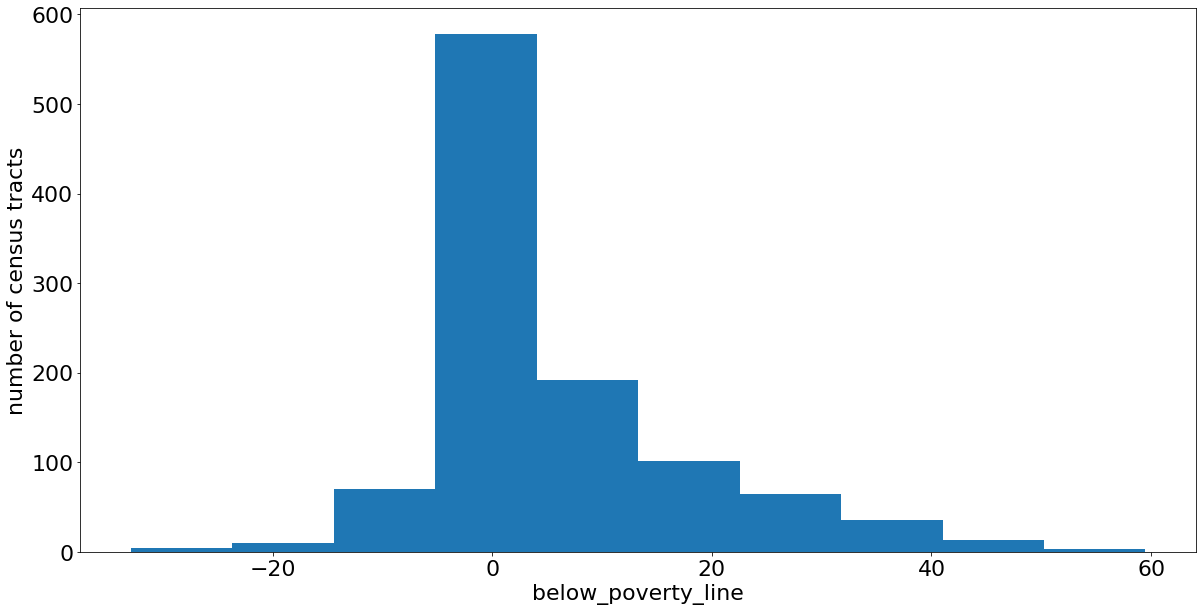

In [196]:
plt.figure(figsize=(20, 10))
plt.hist(100 * ct_stats_df_cleaned['children_poverty_pct'] - ct_stats_df_cleaned['below_poverty_line'])
plt.xlabel('below_poverty_line')
plt.ylabel('number of census tracts')
plt.show()

In [197]:
ct_stats_df_cleaned.drop(columns=['below_poverty_line'], inplace=True)

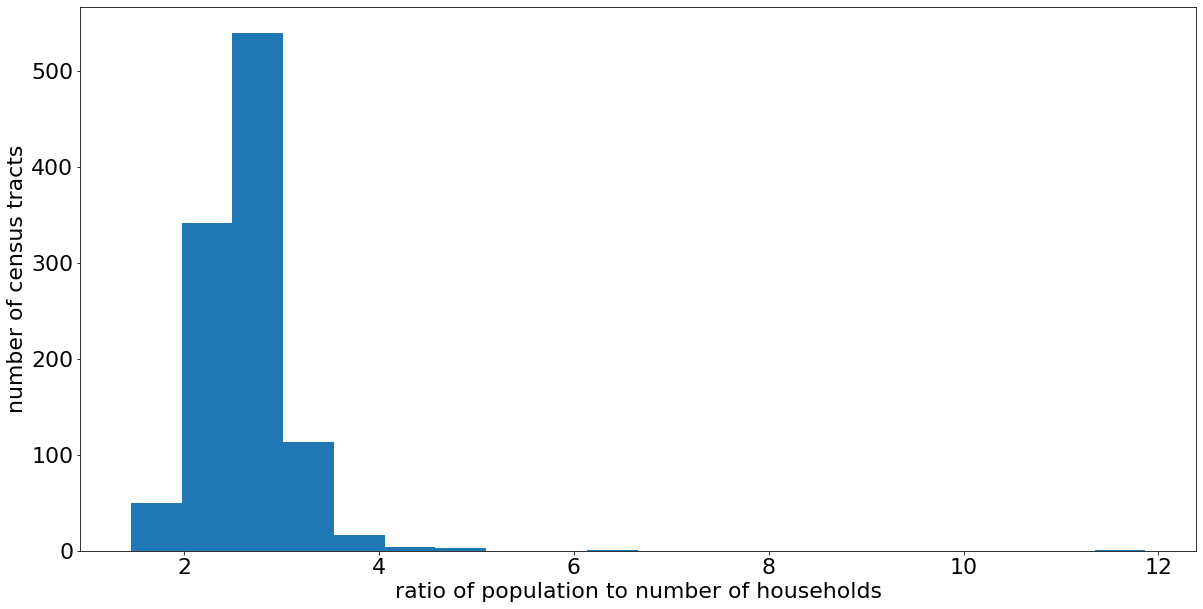

In [198]:
plt.figure(figsize=(20, 10))
plt.hist(ct_stats_df_cleaned['census_population'] / ct_stats_df_cleaned['total_households'], bins=20)
plt.xlabel('ratio of population to number of households')
plt.ylabel('number of census tracts')
plt.show()

In [200]:
ct_stats_df_cleaned.to_csv(f'{data_path}/census_tract_data.csv', index=False)

In [201]:
redundant_columns = [
    'densely_urban_score', 'remote_score', 'built 2000-2009', 'state_index_total_achievement_sd',
    'national_index_total_achievement_sd', 'state_percentile_total_achievement_sd', 
    'state_index_total_achievement_sc', 'state_percentile_total_achievement_sc', 
    'national_index_total_achievement_sc', 'avg_annual_pop_change_since_2010',
    'linear_pop_trend_since_2014', 'avg_annual_pop_change_since_2014',
    'mean_household_income', 'median_family_income', 'mean_family_income', 'vacancy_rate',
    'standardized_test_score_percentile'
]

In [202]:
ct_stats_df_cleaned.drop(columns=redundant_columns, inplace=True, errors='ignore')

In [203]:
ct_stats_df_cleaned.to_csv(f'{data_path}/census_tract_data_removed_redundant_features.csv', index=False)

### MLS Listing Data

In [205]:
market_area_listing_dates_df = pd.read_csv(f'{data_path}/listing_dates_cleaned.csv')
market_area_listing_dates_df['zipcode'] = market_area_listing_dates_df['zipcode'].astype(str)

In [206]:
for event in 'list sale withdrawn expired cancelled'.split():
    column = event + '_date'
    market_area_listing_dates_df[column] = pd.to_datetime(market_area_listing_dates_df[column]).dt.date

In [207]:
market_area_listing_dates_df.head()

,property_id,zipcode,latitude,longitude,list_date,sale_date,withdrawn_date,expired_date,cancelled_date,current_status,list_price,sale_price
0,175039535,1702,42.27250,-71.44128,2015-03-01,2015-04-27,NaT,NaT,NaT,Sale,349900.0,349900.0
1,504787545,2151,42.40187,-70.98765,2015-03-01,NaT,NaT,2015-10-01,NaT,Expired,599000.0,NaN
2,66951764,2445,42.33417,-71.13648,2015-03-07,2015-03-13,NaT,NaT,NaT,Sale,725000.0,745000.0
3,67506746,2536,41.55849,-70.58817,2015-03-09,2015-06-23,NaT,NaT,NaT,Sale,299000.0,299000.0
4,67096343,2052,42.20576,-71.32738,2015-03-11,2015-09-18,NaT,NaT,NaT,Sale,274900.0,274900.0


In [209]:
# shapefile of all census tracts
census_tracts_shapes = gpd.read_file(f'{neighborhood_scout_path}/ct_18states shapefile/ct_18states.shp')
census_tracts_shapes['ct_key'] = census_tracts_shapes['CT_KEY'].astype(int)
census_tracts_shapes.drop(columns='CT_KEY', inplace=True)

# limit analysis to census tracts in state
statewide_census_tracts_shapes = census_tracts_shapes[census_tracts_shapes['ct_key'].
                                                      isin(statewide_census_tracts)]
statewide_census_tracts_shapes.shape

(1471, 2)

In [210]:
# convert the latitude and longitude of each listing to a Point
geometry = [Point(xy) for xy in zip(market_area_listing_dates_df.longitude, 
                                    market_area_listing_dates_df.latitude)]
gdf = gpd.GeoDataFrame(market_area_listing_dates_df, crs='EPSG:4269', geometry=geometry)

# identify the census tract that each listing lies within
merged_file = gpd.sjoin(gdf, statewide_census_tracts_shapes, how='left', op='within')
market_area_listing_dates_ct_df = pd.DataFrame(merged_file)

In [211]:
market_area_listing_dates_ct_df.head()

,property_id,zipcode,latitude,longitude,list_date,sale_date,withdrawn_date,expired_date,cancelled_date,current_status,list_price,sale_price,geometry,index_right,ct_key
0,175039535,1702,42.27250,-71.44128,2015-03-01,2015-04-27,NaT,NaT,NaT,Sale,349900.0,349900.0,POINT (-71.44128 42.27250),23075.0,2.501738e+10
1,504787545,2151,42.40187,-70.98765,2015-03-01,NaT,NaT,2015-10-01,NaT,Expired,599000.0,NaN,POINT (-70.98765 42.40187),22163.0,2.502517e+10
2,66951764,2445,42.33417,-71.13648,2015-03-07,2015-03-13,NaT,NaT,NaT,Sale,725000.0,745000.0,POINT (-71.13648 42.33417),21917.0,2.502140e+10
3,67506746,2536,41.55849,-70.58817,2015-03-09,2015-06-23,NaT,NaT,NaT,Sale,299000.0,299000.0,POINT (-70.58817 41.55849),21951.0,2.500101e+10
4,67096343,2052,42.20576,-71.32738,2015-03-11,2015-09-18,NaT,NaT,NaT,Sale,274900.0,274900.0,POINT (-71.32738 42.20576),21783.0,2.502141e+10


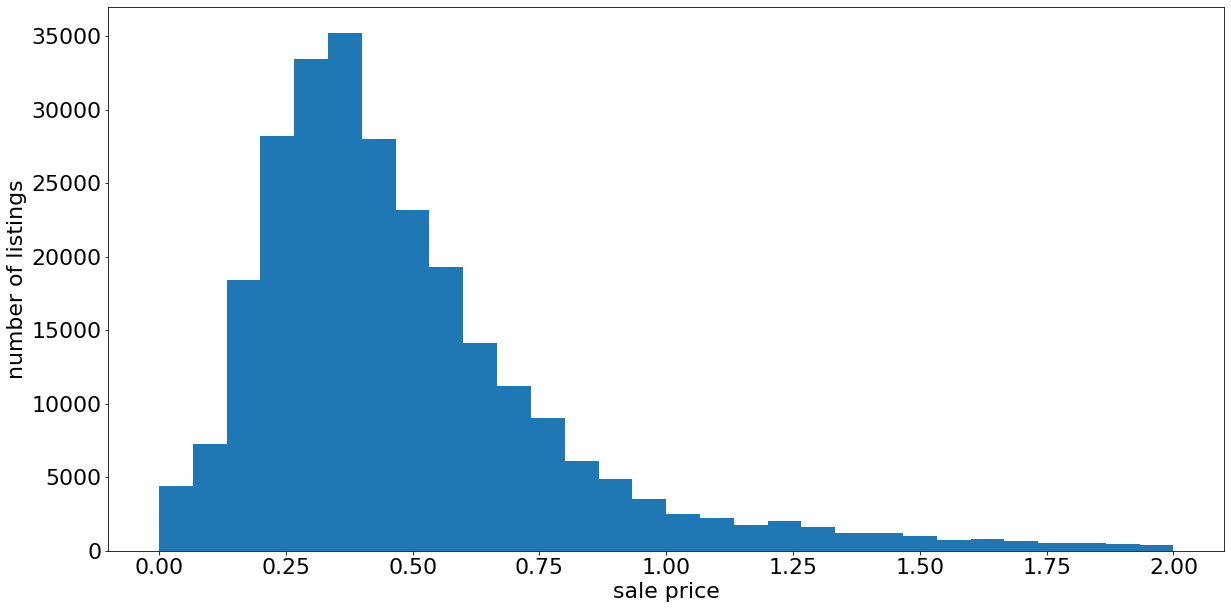

In [212]:
plt.figure(figsize=(20, 10))
plt.hist([x / 1e6 for x in market_area_listing_dates_ct_df['sale_price'] if pd.notnull(x) and x < 2e6], bins=30)
plt.xlabel('sale price')
plt.ylabel('number of listings')
plt.show()

In [213]:
market_area_listing_dates_ct_df.isna().sum()

property_id            0
zipcode                0
latitude             289
longitude            289
list_date              0
sale_date         172634
withdrawn_date    391847
expired_date      398895
cancelled_date    424390
current_status         0
list_price         87576
sale_price        172746
geometry               0
index_right          888
ct_key               888
dtype: int64

In [214]:
len(market_area_listing_dates_ct_df)

440840

In [215]:
# ignore the listings that aren't matched up with a census tracts
market_area_listing_dates_ct_df = market_area_listing_dates_ct_df[market_area_listing_dates_ct_df['ct_key'].notna()]

In [216]:
market_area_listing_dates_ct_df.isna().sum()

property_id            0
zipcode                0
latitude               0
longitude              0
list_date              0
sale_date         172126
withdrawn_date    390992
expired_date      398178
cancelled_date    423552
current_status         0
list_price         87377
sale_price        172238
geometry               0
index_right            0
ct_key                 0
dtype: int64

In [217]:
final_census_tracts = set(ct_stats_df_cleaned['ct_key'])

In [219]:
print(len(market_area_listing_dates_ct_df))
market_area_listing_dates_ct_df = market_area_listing_dates_ct_df[
    market_area_listing_dates_ct_df['ct_key'].isin(final_census_tracts)]
print(len(market_area_listing_dates_ct_df))

437721
437721


In [220]:
market_area_listing_dates_ct_df.to_csv(f'{data_path}/listing_dates_with_ct.csv', index=False)